In [ ]:
!pip install rasterio

In [ ]:
# Import libraries
import pandas as pd
import geopandas as gpd
import os
from shapely.geometry import Point
from shapely import wkt
import numpy as np
import shapely
from shapely.geometry import shape
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mount on the Google Drive

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
path = "/content/drive/My Drive/Hands-on Data Science/Hands-on Data Science_Project/"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['NYC.shp',
 'NYC.qmd',
 'NYC.prj',
 'NYC.shx',
 'NYC.dbf',
 'NYC.cpg',
 'f_deviation_smooth.tif',
 'data',
 'building_p.shp.xml',
 'building_p.shx',
 'building_p.shp',
 'building_p.prj',
 'building_p.dbf',
 'Average_Temperatures_in_Each_Grid_4.png',
 'Average_Temperatures_in_Each_Grid_5.png',
 'Average_Temperatures_in_Each_Grid_6.png',
 'Average_Temperatures_in_Each_Grid_7.png',
 'Average_Temperatures_in_Each_Grid_8.png',
 'Average_Temperatures_in_Each_Grid_9.png',
 'Average_Temperatures_in_Each_Grid_10.png',
 'Average_Temperatures_in_Each_Grid_11.png',
 'Average_Temperatures_in_Each_Grid_12.png',
 'Average_Temperatures_in_Each_Grid_13.png',
 'Average_Temperatures_in_Each_Grid_14.png',
 'Average_Temperatures_in_Each_Grid_15.png',
 'Average_Temperatures_in_Each_Grid_16.png',
 'Average_Temperatures_in_Each_Grid_17.png',
 'Average_Temperatures_in_Each_Grid_18.png',
 'Average_Temperatures_in_Each_Grid_19.png',
 'Average_Carbon Emission from buildings_in_Each_Grid_4NYC.png',
 'Average_Carb

In [ ]:

file_1_path = 'data/NYC_Building_Energy_and_Water_Data_Disclosure_for_Local_Law_84__2022-Present__20241011.csv'

# Reading the CSV files
df_energy_all = pd.read_csv(file_1_path, low_memory=False)


In [ ]:
print('NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present')
print(df_energy_all.head())
print('NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present Data shape')
print(df_energy_all.shape)

NYC Building Energy and Water Data Disclosure for Local Law 84 2022-Present
   Calendar Year  Property ID              Property Name  \
0           2022      6414946         58-01 Grand Avenue   
1           2022      9793770  1870 Pelham Parkway South   
2           2022     10177418           Central Building   
3           2022     13511507       215 East 99th Street   
4           2022     14009907            23-25 31 Street   

                    Parent Property ID                 Parent Property Name  \
0  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
1  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
2  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
3  Not Applicable: Standalone Property  Not Applicable: Standalone Property   
4  Not Applicable: Standalone Property  Not Applicable: Standalone Property   

  Year Ending NYC Borough, Block and Lot (BBL)  \
0  12/31/2022                       40

In [ ]:
print("Print all column names:\n",df_energy_all.columns)

Print all column names:
 Index(['Calendar Year', 'Property ID', 'Property Name', 'Parent Property ID',
       'Parent Property Name', 'Year Ending',
       'NYC Borough, Block and Lot (BBL)',
       'NYC Building Identification Number (BIN)', 'Address 1', 'City',
       ...
       'Aggregate Meter(s)-District Steam – Number of Individual Meters Included',
       'Report Generation Date', 'Report Submission Date', 'Borough',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract (2020)', 'Neighborhood Tabulation Area (NTA) (2020)'],
      dtype='object', length=265)


In [ ]:
# selecting specific columns
columns_to_select = ['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude', 'Longitude', 'ENERGY STAR Score','Total (Location-Based) GHG Emissions (Metric Tons CO2e)','Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built','Borough','Neighborhood Tabulation Area (NTA) (2020)']
# Creating a new DataFrame with only the selected columns
df_energy = df_energy_all[columns_to_select]

print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  
0                                    QN0501  
1                                    BX1003  
2                                    QN1401  
3                                    MN1101  
4                                    QN0101

In [ ]:
print('Filtered Data shape')
print(df_energy.shape)

Filtered Data shape
(64169, 11)


## Feature engineering - get a 'sum floor area' column

In [ ]:
df_gross_floor_area = df_energy_all.filter(like='Gross Floor Area (ft²)')
# Display the first few rows to verify
df_gross_floor_area = df_gross_floor_area.drop(['Largest Property Use Type - Gross Floor Area (ft²)',
                                          '2nd Largest Property Use Type - Gross Floor Area (ft²)',
                                          '3rd Largest Property Use Type - Gross Floor Area (ft²)'], axis=1)


In [ ]:
#calculating the sum floor area and store it in a column
df_gross_floor_area.replace('Not Available', 0, inplace=True)

df_gross_floor_area = df_gross_floor_area.apply(pd.to_numeric, errors='coerce')

df_gross_floor_area.fillna(0, inplace=True)

df_gross_floor_area_withsum = df_gross_floor_area.copy()

df_gross_floor_area_withsum['sum floor area'] = df_gross_floor_area_withsum.sum(axis=1)

print('Calculated sum floor area')
df_gross_floor_area_withsum.head()





<ipython-input-184-65f2f5eb4ff4>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_gross_floor_area.replace('Not Available', 0, inplace=True)


Calculated sum floor area


Data Center - Gross Floor Area (ft²)  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   

   Adult Education - Gross Floor Area (ft²)  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   Ambulatory Surgical Center - Gross Floor Area (ft²)  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Vehicle Dealership - Gross Floor Area (ft²)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Bank Branch - Gross Floor Area (ft²)  Barracks- Gross Floor Area (ft²)  \
0                                   0.0                                 0   
1                                   0.0                                 0   
2                                   0.0                                 0   
3                                   0.0                                 0   
4                                   0.0                                 0   

   College/University - Gross Floor Area (ft²)  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   Convention Center - Gross Floor Area (ft²)  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   Courthouse - Gross Floor Area (ft²)  \
0                                    0   
1                                    0   
2                                    0   
3                                    0   
4                                    0   

   Distribution Center - Gross Floor Area (ft²)  ...  \
0                                           0.0  ...   
1                                           0.0  ...   
2                                           0.0  ...   
3                                           0.0  ...   
4                                           0.0  ...   

   Retail Store - Gross Floor Area (ft²)  \
0                                    0.0   
1                                    0.0   
2                                17598.0   
3                                    0.0   
4                                    0.0   

   Self-Storage Facility - Gross Floor Area (ft²)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Senior Living Community - Gross Floor Area (ft²)  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   

   Social/Meeting Hall - Gross Floor Area (ft²)  \
0                                             0   
1                                             0   
2                                             0   
3                                          

In [ ]:
#add it to the df_energy
df_energy['sum floor area']=df_gross_floor_area_withsum['sum floor area']

<ipython-input-185-16d0ba587f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['sum floor area']=df_gross_floor_area_withsum['sum floor area']


In [ ]:
print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  sum floor area  
0                                    QN0501         51749.0  
1                                    BX1003         52941.0  
2                                    QN1401         35196.0  
3                                    MN1101        107234.0  
4                                    QN0101         75191.0

In [ ]:
# Simplify column names: Keep the part before ' - '
df_gross_floor_area.columns = [col.split('- ')[0] for col in df_gross_floor_area.columns]

# Apply one-hot encoding: Find the index of the maximum value and set that to the corresponding column name
df_gross_floor_area['major use type'] = df_gross_floor_area.apply(lambda row: row.idxmax(), axis=1)

# Display the first few rows to verify the result
print('First few rows with major use type:')
df_gross_floor_area[['major use type']].head()

First few rows with major use type:


major use type
0  Non-Refrigerated Warehouse 
1         Multifamily Housing 
2                      Office 
3         Multifamily Housing 
4              Medical Office

In [ ]:
#add it to the df_energy
df_energy['major use type']=df_gross_floor_area['major use type']

<ipython-input-188-fcdb9ca9c1f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['major use type']=df_gross_floor_area['major use type']


In [ ]:
print('head rows of df_energy')
df_energy.head()

head rows of df_energy


NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009     Not Available   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

  Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9        
1                                              216.1        
2                                              163.1        
3                                              457.3        
4                                              320.9        

  Net Emissions (Metric Tons CO2e)  Calendar Year  Year Built    Borough  \
0                             29.9           2022        1930     QUEENS   
1                            216.1           2022        1960      BRONX   
2                            163.1           2022        1941     QUEENS   
3                            457.3           2022        1898  MANHATTAN   
4                            320.9           2022        1911     QUEENS   

  Neighborhood Tabulation Area (NTA) (2020)  sum floor area  \
0                                    QN0501         51749.0   
1                                    BX1003         52941.0   
2                                    QN1401         35196.0   
3                                    MN1101        107234.0   
4                                    QN0101         75191.0   

                major use type  
0  Non-Refrigerated Warehouse   
1         Multifamily Housing   
2                      Office   
3         Multifamily Housing   
4              Medical Office

At this stage I already decide to do feature engineering to get sum floor area and major use type, which are 2 potential relevant variables to total GHG emissions.

#EDA
The goal of EDA is to gain an initial understanding of the dataset, identify patterns, detect missing data, and explore relationships between features.

##Summary Statistics:
###Continuous data:
'Latitude', 'Longitude',  'Total (Location-Based) GHG Emissions (Metric Tons CO2e)', 'Net Emissions (Metric Tons CO2e)', 'sum floor area'
  
###Ordinal data:
'ENERGY STAR Score'  
  
###Categorical data:
'NYC Building Identification Number (BIN)', 'Property Name', 'Borough', 'Neighborhood Tabulation Area (NTA) (2020)', 'Calendar Year', 'Year Built','major use type'

In [ ]:
print(df_energy.dtypes)

NYC Building Identification Number (BIN)                    object
Property Name                                               object
Latitude                                                   float64
Longitude                                                  float64
ENERGY STAR Score                                           object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)     object
Net Emissions (Metric Tons CO2e)                            object
Calendar Year                                                int64
Year Built                                                   int64
Borough                                                     object
Neighborhood Tabulation Area (NTA) (2020)                   object
sum floor area                                             float64
major use type                                              object
dtype: object


In [ ]:
# Converting the columns to float
df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')
df_energy['Net Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Net Emissions (Metric Tons CO2e)'], errors='coerce')

# Verifying the data types after conversion
print(df_energy.dtypes)
print(df_energy[['Total (Location-Based) GHG Emissions (Metric Tons CO2e)', 'Net Emissions (Metric Tons CO2e)']].dtypes)

NYC Building Identification Number (BIN)                    object
Property Name                                               object
Latitude                                                   float64
Longitude                                                  float64
ENERGY STAR Score                                           object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    float64
Net Emissions (Metric Tons CO2e)                           float64
Calendar Year                                                int64
Year Built                                                   int64
Borough                                                     object
Neighborhood Tabulation Area (NTA) (2020)                   object
sum floor area                                             float64
major use type                                              object
dtype: object
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    float64
Net Emissions (Metric Tons CO2e)                

<ipython-input-191-f87d8c325fe3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')
<ipython-input-191-f87d8c325fe3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy['Net Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_energy['Net Emissions (Metric Tons CO2e)'], errors='coerce')


In [ ]:
columns_continuous = ['Latitude', 'Longitude', 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
                      'Net Emissions (Metric Tons CO2e)','sum floor area']
df_energy[columns_continuous].describe()

Latitude     Longitude  \
count  61790.000000  61790.000000   
mean      40.747879    -73.936054   
std        0.078342      0.064506   
min       40.509037    -74.244118   
25%       40.697285    -73.978987   
50%       40.750050    -73.946978   
75%       40.810227    -73.900956   
max       40.912869    -73.700935   

       Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
count                                       6.271200e+04         
mean                                        9.141075e+02         
std                                         2.057174e+04         
min                                        -4.390000e+01         
25%                                         1.602000e+02         
50%                                         2.922000e+02         
75%                                         5.585000e+02         
max                                         3.139712e+06         

       Net Emissions (Metric Tons CO2e)  sum floor area  
count                      6.322200e+04    6.416900e+04  
mean                       8.105927e+02    1.277157e+05  
std                        9.198873e+03    3.219850e+05  
min                       -8.385100e+03    0.000000e+00  
25%                        1.819000e+02    3.600000e+04  
50%                        3.165000e+02    6.088300e+04  
75%                        6.089750e+02    1.168970e+05  
max                        2.206863e+06    2.204270e+07

In [ ]:
# Frequency counts for ordinal data
df_energy['ENERGY STAR Score'].value_counts()


ENERGY STAR Score
Not Available    15130
100               3804
1                 1078
99                 823
86                 760
                 ...  
8                  237
9                  236
13                 233
7                  225
16                 225
Name: count, Length: 101, dtype: int64

In [ ]:
# Summary statistics for ordinal data
df_energy['ENERGY STAR Score'].describe()


count             64169
unique              101
top       Not Available
freq              15130
Name: ENERGY STAR Score, dtype: object

In [ ]:

columns_categorical = ['NYC Building Identification Number (BIN)', 'Property Name', 'Borough',
'Neighborhood Tabulation Area (NTA) (2020)', 'Calendar Year', 'Year Built','major use type']
for column in columns_categorical:
    print(f"\nFrequency counts for {column}:")
    print(df_energy[column].value_counts())



Frequency counts for NYC Building Identification Number (BIN):
NYC Building Identification Number (BIN)
Not Available              627
2123911                    190
2999999                     93
4999999                     50
0                           49
                          ... 
3326541                      1
3326506                      1
3326556                      1
1078514;1078516;1078512      1
2085311                      1
Name: count, Length: 31136, dtype: int64

Frequency counts for Property Name:
Property Name
University Center                              6
Main Building                                  6
Cross Bronx Pres LLC - Baychester (2166bay)    6
Alumni Hall                                    6
29-07 31st Ave                                 6
                                              ..
247 Dumont Avenue                              1
190 Riverdale Avenue                           1
338 Bristol Street                             1
392 Bristol Street   

##Missing Data:
###Check for missing values using isnull().sum() and evaluate which columns have missing data.

  
###Plot missing data distribution using heatmaps (sns.heatmap()) to identify patterns  

In [ ]:
df_energy.replace('Not Available', np.nan, inplace=True)
df_energy.isnull().sum()

<ipython-input-196-b51e0c231f9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_energy.replace('Not Available', np.nan, inplace=True)


NYC Building Identification Number (BIN)                     627
Property Name                                                  0
Latitude                                                    2379
Longitude                                                   2379
ENERGY STAR Score                                          15130
Total (Location-Based) GHG Emissions (Metric Tons CO2e)     1457
Net Emissions (Metric Tons CO2e)                             947
Calendar Year                                                  0
Year Built                                                     0
Borough                                                     2376
Neighborhood Tabulation Area (NTA) (2020)                   2378
sum floor area                                                 0
major use type                                                 0
dtype: int64

In [ ]:
# Calculate the fraction of null values in each column
null_fractions = df_energy.isnull().sum() / len(df_energy)

# Display the fraction of nulls
print("Fraction of null values in each column:")
print(null_fractions)

Fraction of null values in each column:
NYC Building Identification Number (BIN)                   0.009771
Property Name                                              0.000000
Latitude                                                   0.037074
Longitude                                                  0.037074
ENERGY STAR Score                                          0.235784
Total (Location-Based) GHG Emissions (Metric Tons CO2e)    0.022706
Net Emissions (Metric Tons CO2e)                           0.014758
Calendar Year                                              0.000000
Year Built                                                 0.000000
Borough                                                    0.037027
Neighborhood Tabulation Area (NTA) (2020)                  0.037058
sum floor area                                             0.000000
major use type                                             0.000000
dtype: float64


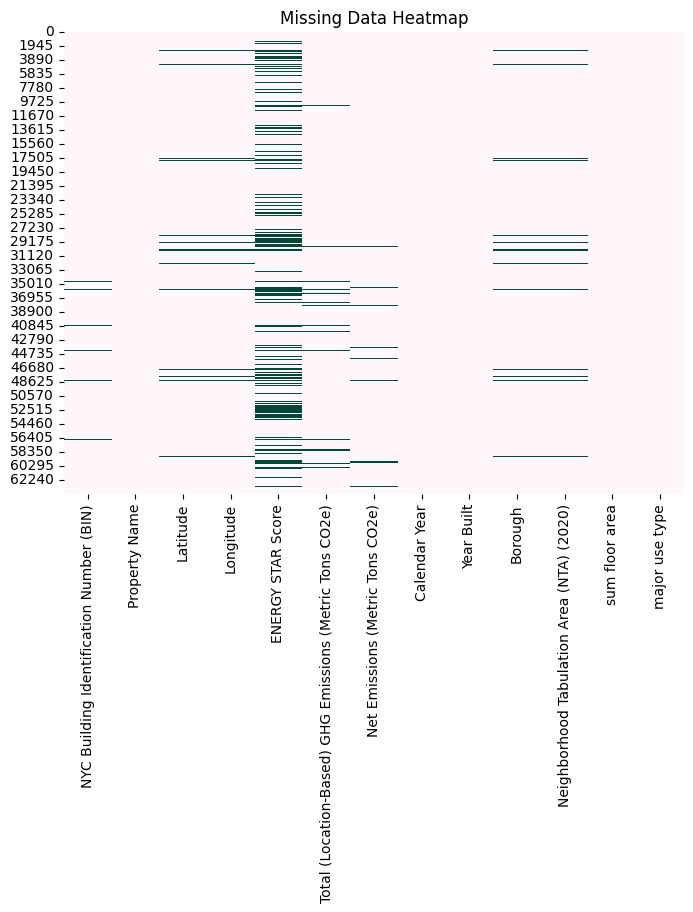

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size for better readability
plt.figure(figsize=(8, 6))

# Heatmap with a different colormap for better contrast
sns.heatmap(df_energy.isnull(), cmap='PuBuGn', cbar=False)

plt.title('Missing Data Heatmap')
plt.show()


We can see that, for columns other than ENERBY STAR Score, only a small percentage of rows have missing data, so dropping them won't significantly reduce the size of your dataset.

Data imputation is not feasible especially for the data missing Latitude and Longtitude. For those which have Latitude and Longtituede but missing the important CO2 emission values, inferring them would be difficult without building model based on the some relevant factors.

When we need the building energy information as much as we can to calculate the effect of it on regional carbon emission, data imputation may be reasonable. However, the data imputation with mean or median may be very inaccurate based on that the CO2 emission varies greatly depending on size of the building, use types, etc. The reasonable data imputation needs a model. To build this model, dropping all the rows with missing values is the most efficient way of dealing with missing values before the model is built.

So I ignore 'ENERBY STAR Score' column first and drop all the rows have NA in other columns. This data do not lose completeness. Leaving some NA in 'ENERBY STAR Score' is better than unreasonable data imputation because the NAs in this columns is almost one fifth of the total data number.

In [ ]:
df_clean = df_energy.dropna(subset=[col for col in df_energy.columns if col != 'ENERGY STAR Score'])

print('The shape of dataframe after dropping NAs (except ENERGY STAR Score) is:', df_clean.shape)

The shape of dataframe after dropping NAs (except ENERGY STAR Score) is: (59420, 13)


In [ ]:


# Check to ensure there are no NaN values left in the 'ENERGY STAR Score' column
print(df_clean['ENERGY STAR Score'].isnull().sum(), "missing values left in 'ENERGY STAR Score'")


11945 missing values left in 'ENERGY STAR Score'


## Data Engineering-adding the temperature

In [ ]:
import rasterio
from rasterio.warp import transform
# Load the reprojected raster
raster_path = 'data/f_deviation_smooth_32618.tif'
raster = rasterio.open(raster_path)

# Convert the Lat/Lon columns in df_clean to geometry points (WGS84)
df_clean['geometry'] = df_clean.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert the GeoDataFrame to a consistent CRS (WGS84 EPSG:4326)
gdf_clean = gpd.GeoDataFrame(df_clean, geometry='geometry', crs='EPSG:4326')

# Reproject the points to the raster's CRS (EPSG:32618)
gdf_clean = gdf_clean.to_crs(32618)

# Function to extract the temperature at each point from the raster
def extract_temperature(point, raster):
    try:
        # Extract the pixel value at the point location
        coords = [(point.x, point.y)]
        for val in raster.sample(coords):
            if val[0] != raster.nodata:
                return val[0]
            else:
                return np.nan
    except Exception as e:
        print(f"Error extracting temperature for point {point}: {e}")
        return np.nan

# Apply the temperature extraction function to each row in the GeoDataFrame
gdf_clean['temperature'] = gdf_clean['geometry'].apply(lambda point: extract_temperature(point, raster))

# Convert back to the original DataFrame (dropping the 'geometry' column)
df_clean['temperature'] = gdf_clean['temperature']

# Display the first few rows to verify
print('Display the first few rows to verify the temperature is added to the building energy dataframe')
print(df_clean.head())




<ipython-input-201-04810c3b8e87>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['geometry'] = df_clean.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)


Display the first few rows to verify the temperature is added to the building energy dataframe
  NYC Building Identification Number (BIN)              Property Name  \
0                                  4059918         58-01 Grand Avenue   
1                                  2047795  1870 Pelham Parkway South   
2                                  4300145           Central Building   
3                                  1052383       215 East 99th Street   
4                                  4017180            23-25 31 Street   

    Latitude  Longitude ENERGY STAR Score  \
0  40.719667 -73.911197                96   
1  40.855488 -73.830726                61   
2  40.604320 -73.753009               NaN   
3  40.786963 -73.947537                64   
4  40.773768 -73.913573                98   

   Total (Location-Based) GHG Emissions (Metric Tons CO2e)  \
0                                               29.9         
1                                              216.1         
2        

<ipython-input-201-04810c3b8e87>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['temperature'] = gdf_clean['temperature']


<ipython-input-202-5b9badeb9b74>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered1['geometry'] = df_clean_filtered1.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)


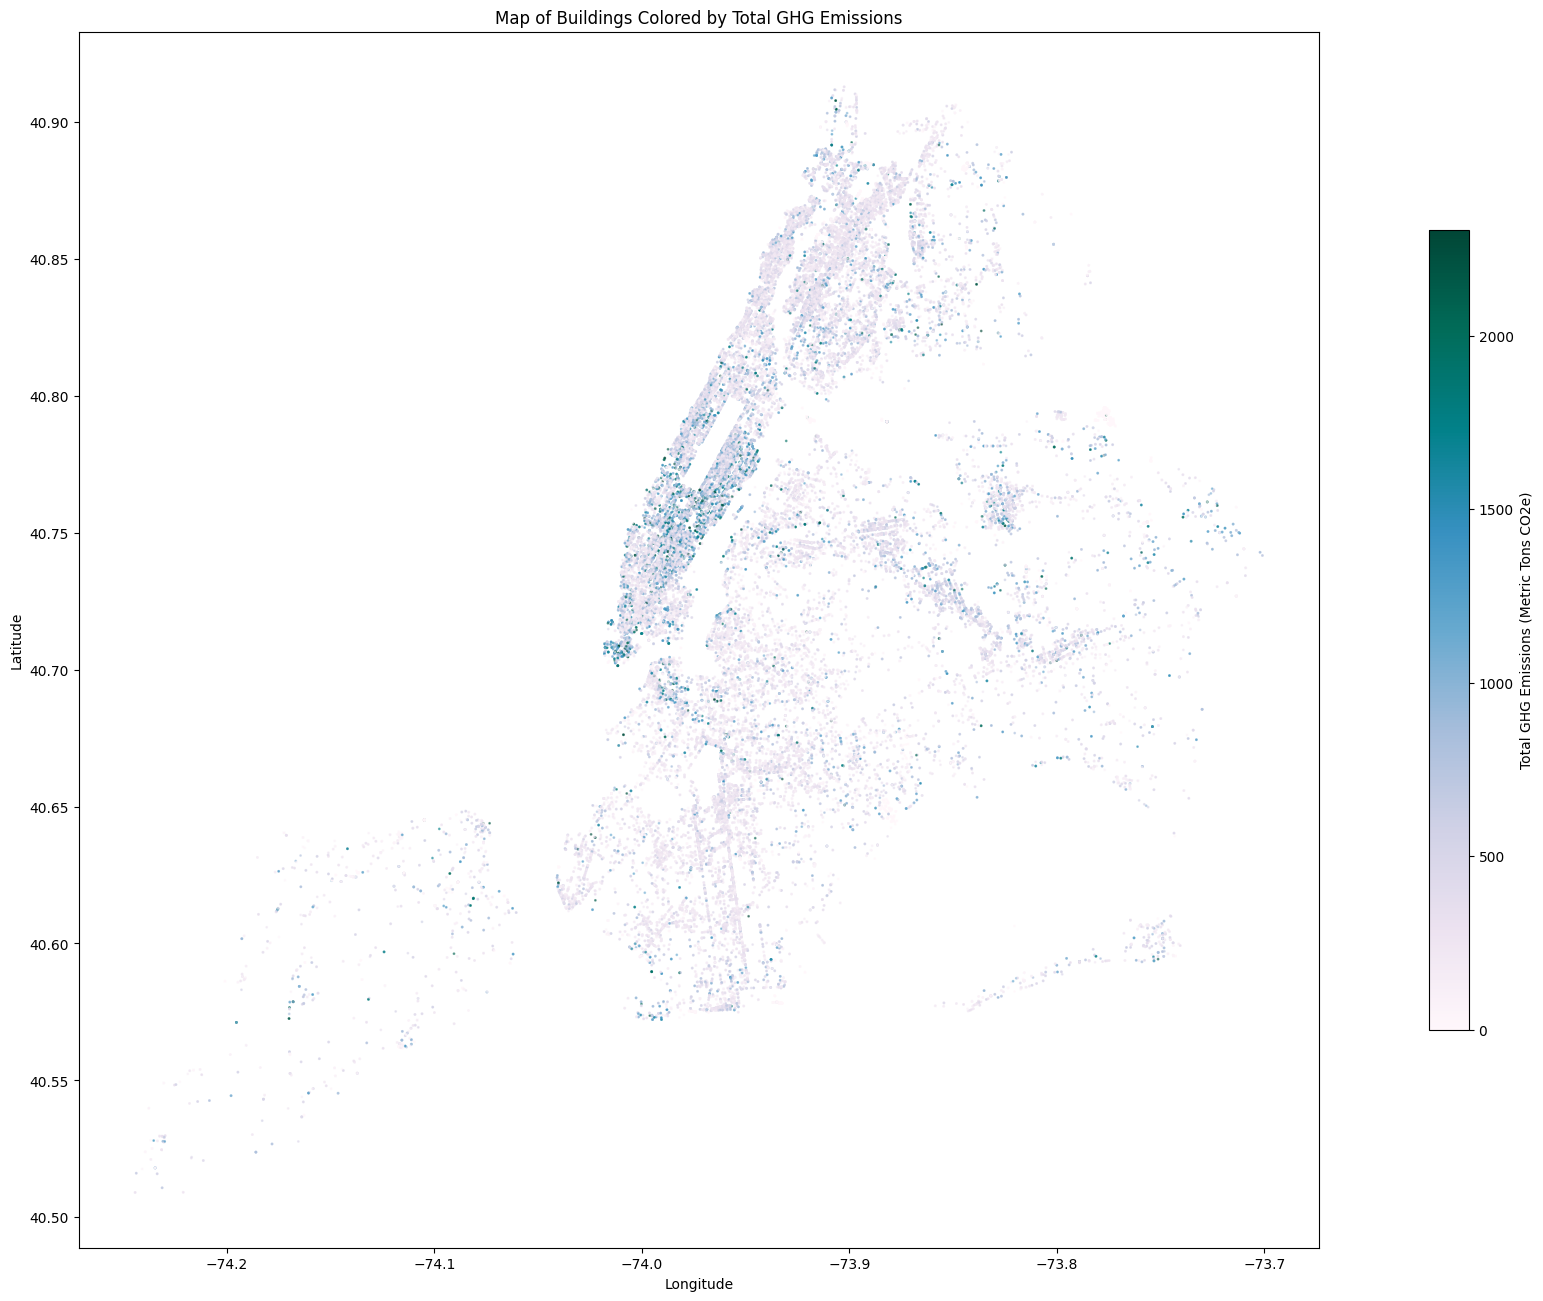

In [ ]:
import geopandas as gpd


ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)
sum_threshold = df_clean['sum floor area'].quantile(0.95)

# Filter the DataFrame based on both conditions
df_clean_filtered1 = df_clean[(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold) &
                              (df_clean['sum floor area'] <= sum_threshold)]

# Ensure that the DataFrame has a valid geometry column
df_clean_filtered1['geometry'] = df_clean_filtered1.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)

# Convert df_clean to a GeoDataFrame
gdf_clean = gpd.GeoDataFrame(df_clean_filtered1, geometry='geometry')

# Set the CRS to WGS84 (since the coordinates are in Latitude and Longitude)
gdf_clean.set_crs(epsg=4326, inplace=True)

# Reproject to CRS EPSG:32618
#gdf_clean = gdf_clean.to_crs(epsg=32618)

# Plot the buildings with color based on GHG Emissions
fig, ax = plt.subplots(figsize=(20, 20))

# Plot buildings colored by 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
gdf_clean.plot(column='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               cmap='PuBuGn',  # Colormap for GHG Emissions
               legend=True,
               legend_kwds={'label': "Total GHG Emissions (Metric Tons CO2e)",
                            'orientation': "vertical", 'shrink': 0.9},
               ax=ax,
               markersize=1, alpha=0.5)

# Adjust the color bar position
cbar = ax.get_figure().get_axes()[1]
cbar.set_position([0.8, 0.2, 0.02, 0.6])  # Position: [left, bottom, width, height]


# Set plot title and axis labels
plt.title("Map of Buildings Colored by Total GHG Emissions")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

The map shows that the buildings with the highest GHG emissions are concentrated in Manhattan, as indicated by the darker turquoise colors. This observation could be attributed to the concentration of larger buildings, commercial spaces, and office buildings in Manhattan, which tend to have higher energy demands and, consequently, higher emissions.

##Visualize Key Variables:


In [ ]:
import matplotlib.cm as cm

In [ ]:
print(df_clean.columns)


Index(['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude',
       'Longitude', 'ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built',
       'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
       'sum floor area', 'major use type', 'geometry', 'temperature'],
      dtype='object')


In [ ]:
df_clean.columns = df_clean.columns.str.strip()


In [ ]:
df_clean['ENERGY STAR Score'] = pd.to_numeric(df_clean['ENERGY STAR Score'], errors='coerce')
df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')


<ipython-input-206-0fb95536d8e2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ENERGY STAR Score'] = pd.to_numeric(df_clean['ENERGY STAR Score'], errors='coerce')
<ipython-input-206-0fb95536d8e2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] = pd.to_numeric(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'], errors='coerce')


see what columns now we have
Index(['NYC Building Identification Number (BIN)', 'Property Name', 'Latitude',
       'Longitude', 'ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)', 'Calendar Year', 'Year Built',
       'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
       'sum floor area', 'major use type', 'geometry', 'temperature'],
      dtype='object')


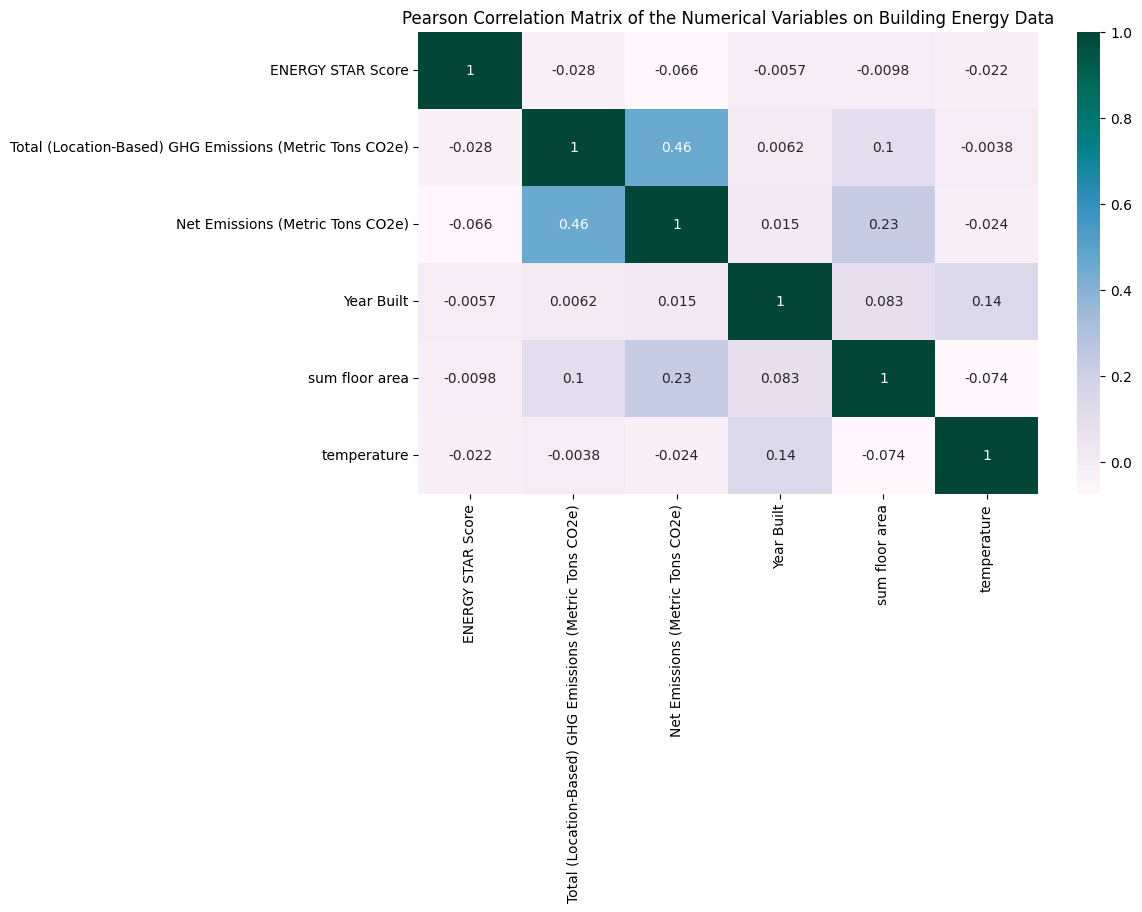

In [ ]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

columns=df_clean.columns
print('see what columns now we have')
print(columns)

# Calculate the correlation matrix
pearson_corr_matrix = df_clean[['ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)',  'Year Built',
       'sum floor area', 'temperature']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(pearson_corr_matrix, annot=True, cmap='PuBuGn')
plt.title('Pearson Correlation Matrix of the Numerical Variables on Building Energy Data')
plt.show()

There are little linear relationship between each variables. except for Total GHG Emissions and Net Emissions. It might be better to explore non-linear relationship.

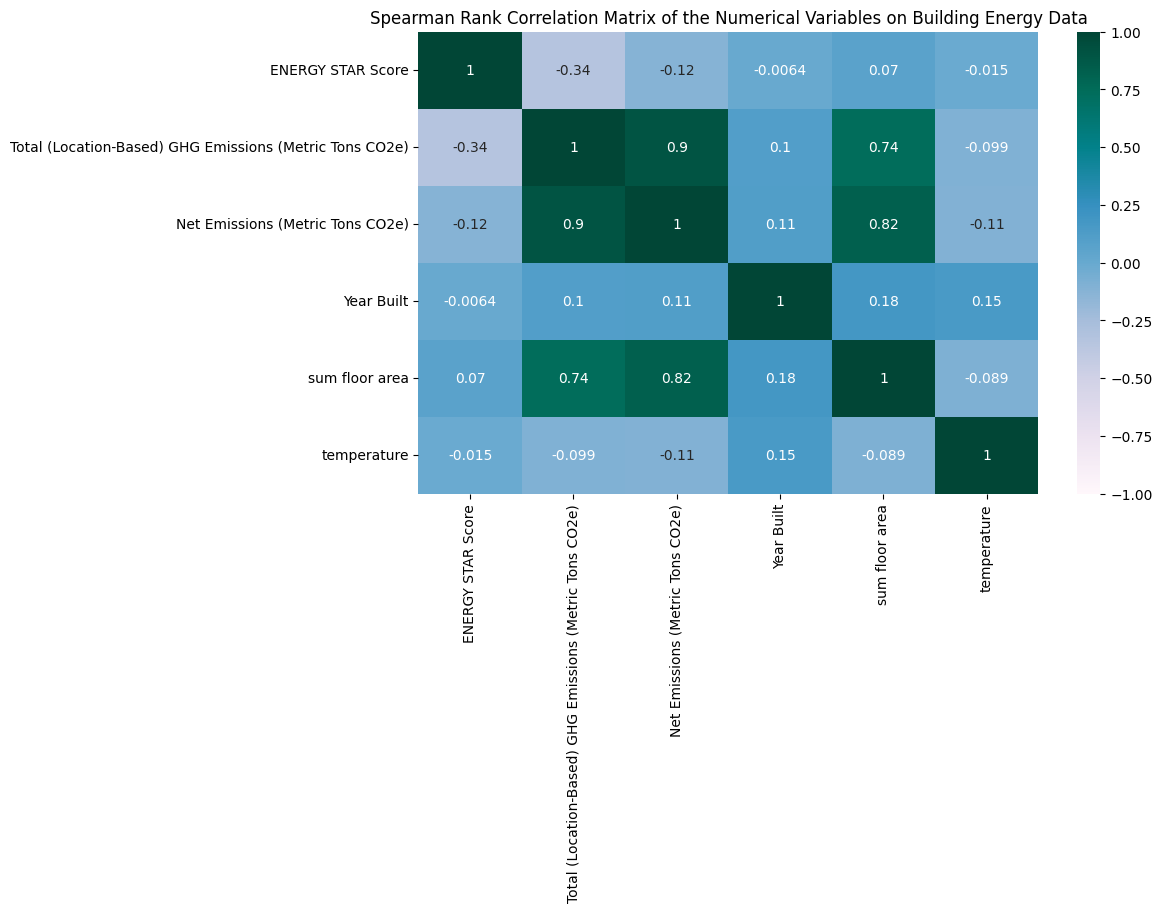

In [ ]:
# Calculate the Spearman correlation matrix
spearman_corr = df_clean[['ENERGY STAR Score',
       'Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
       'Net Emissions (Metric Tons CO2e)',  'Year Built',
       'sum floor area', 'temperature']].corr(method='spearman')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_corr, annot=True, cmap='PuBuGn', center=0, vmin=-1, vmax=1)
plt.title('Spearman Rank Correlation Matrix of the Numerical Variables on Building Energy Data')
plt.show()

From Spearman’s rank correlation matrix, we can see some non-linear relationships:

Total GHG Emissions and Net Emissions (0.9): This is a very high positive Spearman correlation, meaning that as one increases, the other tends to increase in a consistent manner. This relationship could be non-linear, but still monotonic.

Total GHG Emissions and Sum Floor Area (0.74): A strong positive monotonic relationship exists here. Larger floor areas tend to correspond to higher GHG emissions, even if the relationship isn't strictly linear.

Net Emissions and Sum Floor Area (0.82): Again, there's a strong positive monotonic relationship between the size of the building and its emissions, but this relationship might not be linear.

Total GHG Emissions and ENERGY STAR Score (-0.34): This negative correlation suggests that buildings with higher GHG emissions tend to have lower ENERGY STAR scores in a monotonic way. This could mean that increasing GHG emissions generally leads to lower scores, but not in a perfectly linear manner.

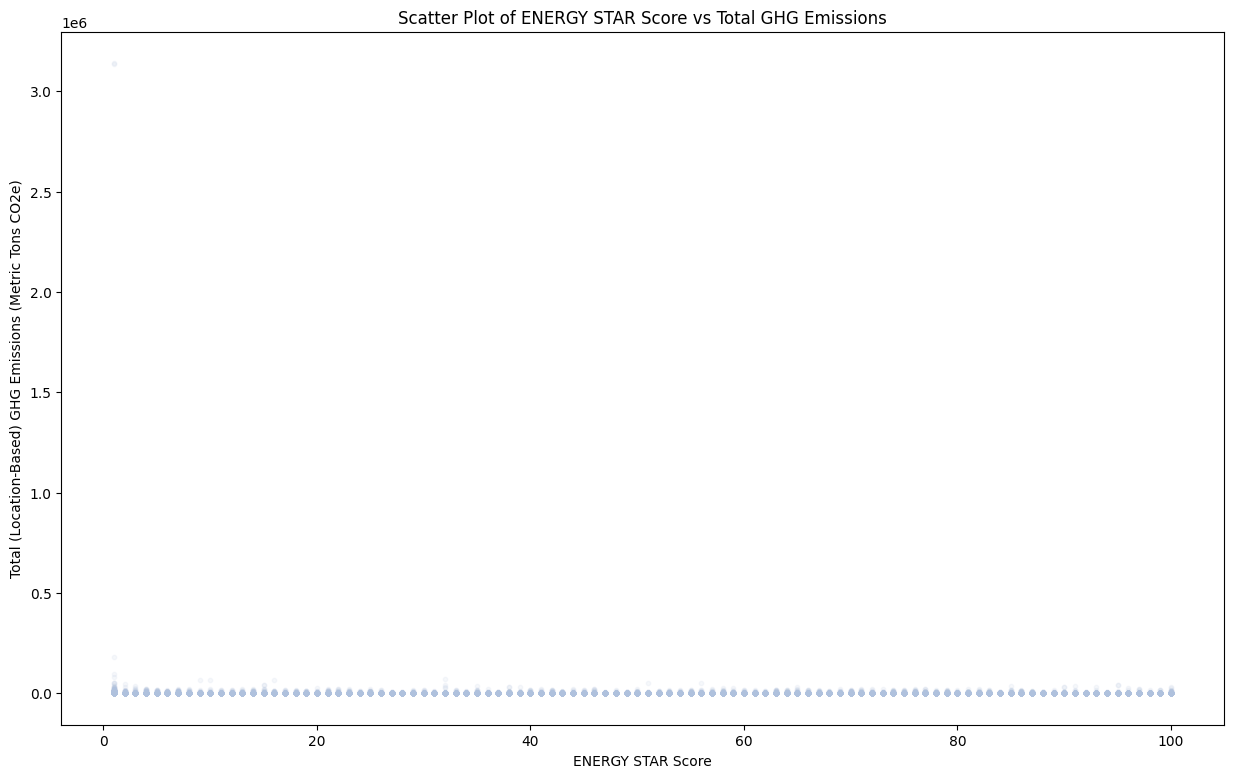

In [ ]:
df_clean.plot.scatter('ENERGY STAR Score','Total (Location-Based) GHG Emissions (Metric Tons CO2e)',figsize=(15,9),alpha=0.1,s=10,c='#afc1dd')
plt.xlabel('ENERGY STAR Score')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of ENERGY STAR Score vs Total GHG Emissions')
plt.show()

Seems like there is some outliers so the plot is not balanced.
So I remove the outlier and plot again.

<ipython-input-210-339aa08b9ba0>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))
<ipython-input-210-339aa08b9ba0>:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')


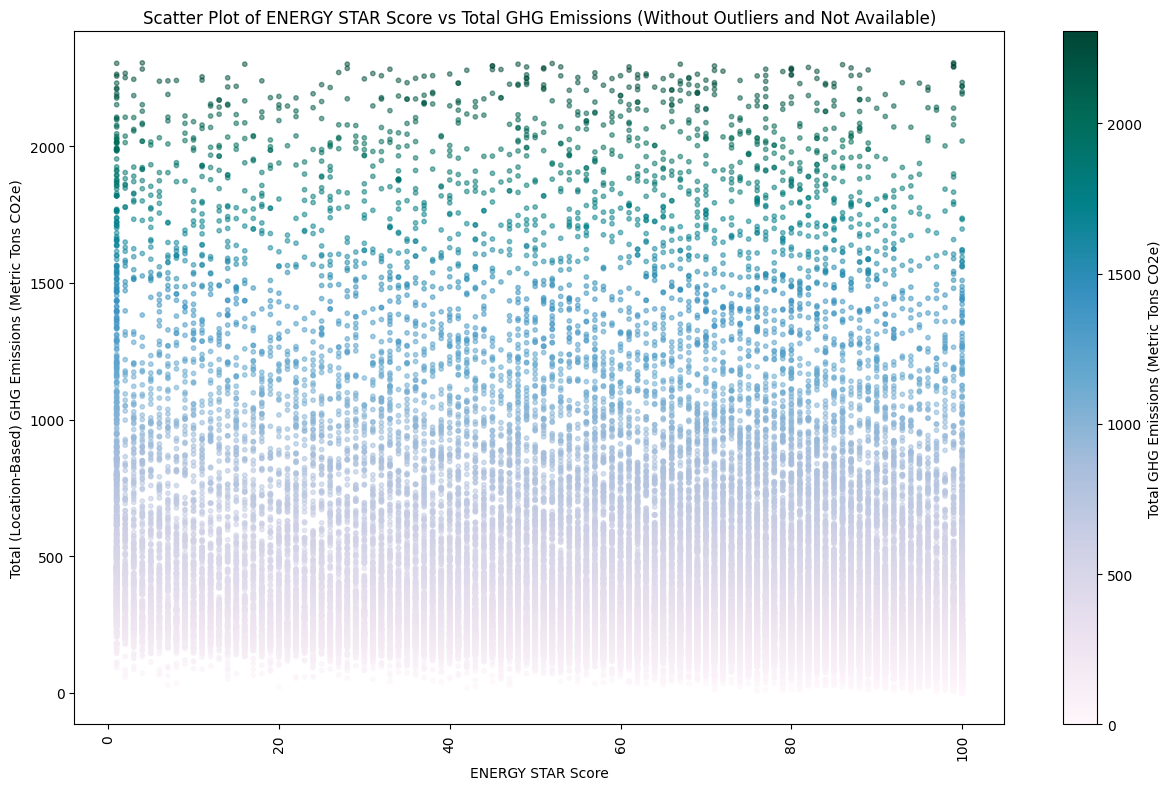

In [ ]:
# Define a threshold using the 95th percentile of the 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)

# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]

df_clean_filtered = df_clean_filtered[df_clean_filtered['ENERGY STAR Score'] != 'Not Available']

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                     vmax=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))



# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered['ENERGY STAR Score'],
            df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10,c=colors)
plt.xlabel('ENERGY STAR Score')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of ENERGY STAR Score vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)

# Add a colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')
plt.show()

No visible pattern can be seen between these 2 variables.

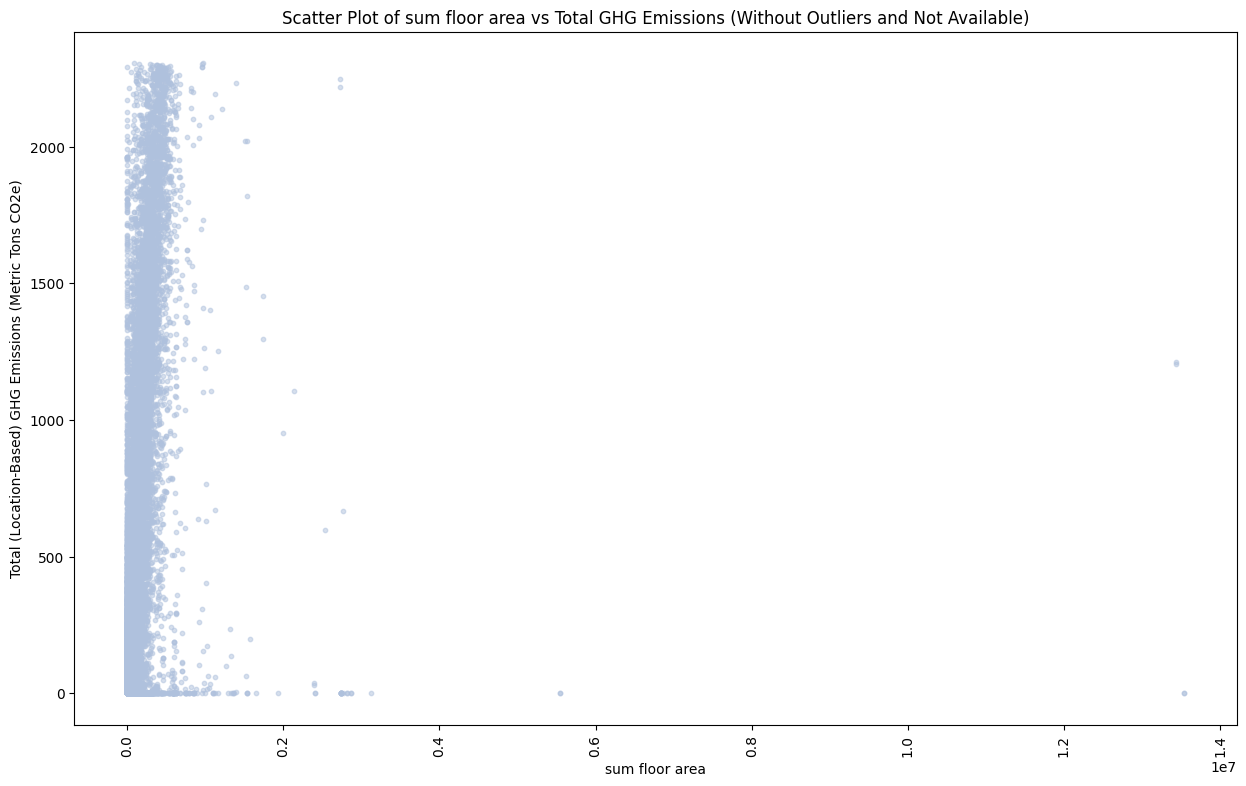

In [ ]:
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)


# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered2 = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]


# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered['sum floor area'],
            df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10,c='#afc1dd')
plt.xlabel('sum floor area')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of sum floor area vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)
plt.show()

We need to remove outliers in 'sum floor area' columns as well.

<ipython-input-212-96e24972b452>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))
<ipython-input-212-96e24972b452>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')


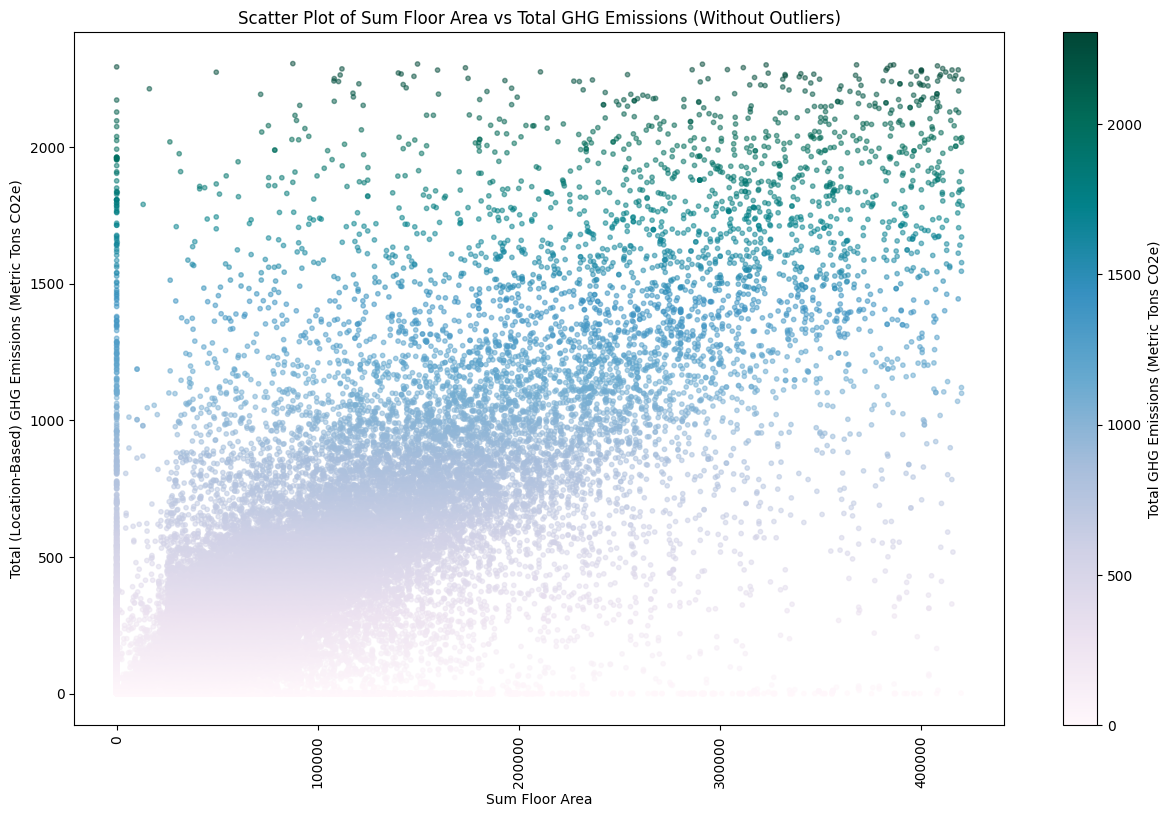

In [ ]:
# Define thresholds
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)
sum_threshold = df_clean['sum floor area'].quantile(0.95)

# Filter the DataFrame based on both conditions
df_clean_filtered2 = df_clean[(df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold) &
                              (df_clean['sum floor area'] <= sum_threshold)]

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                     vmax=df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))

# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered2['sum floor area'], df_clean_filtered2['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10, c=colors)

plt.xlabel('Sum Floor Area')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of Sum Floor Area vs Total GHG Emissions (Without Outliers)')
plt.xticks(rotation=90)

# Add a colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')
plt.show()

We can observe the general trend where the sum floor area increases alongside the GHG emissions, with some clustering around lower values.

<ipython-input-213-a22bf2b99218>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_filtered2['Decade Built'] = (df_clean_filtered2['Year Built'] // 10) * 10
<ipython-input-213-a22bf2b99218>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Decade Built', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',


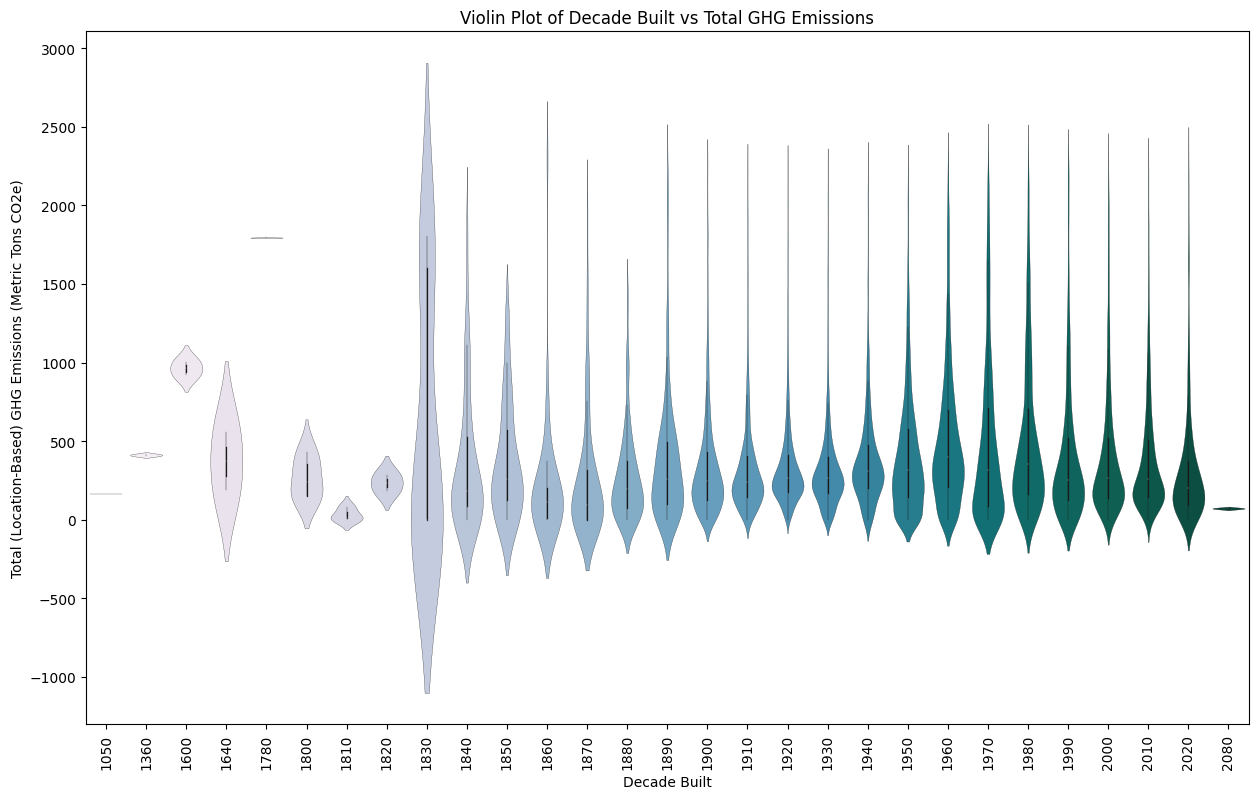

In [ ]:
# Create a new column for decade
df_clean_filtered2['Decade Built'] = (df_clean_filtered2['Year Built'] // 10) * 10

# Create the violin plot for Decade Built
plt.figure(figsize=(15, 9))
sns.violinplot(x='Decade Built', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               data=df_clean_filtered2, palette='PuBuGn',linewidth=0.2)

plt.xticks(rotation=90)
plt.xlabel('Decade Built')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Violin Plot of Decade Built vs Total GHG Emissions')
plt.show()


The data suggests that buildings constructed in the 1830s show a spike in carbon emissions, possibly due to specific construction techniques or building materials used during that era. Another notable peak occurs around the 1970s, which might correspond to large building developments or inefficient energy usage practices during that period.

Additionally, the gradual decrease in carbon emissions for buildings constructed after the 1970s could reflect improvements in building regulations, energy efficiency standards, and construction practices aimed at reducing greenhouse gas emissions.

<ipython-input-214-e1daf449a021>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))
<ipython-input-214-e1daf449a021>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')


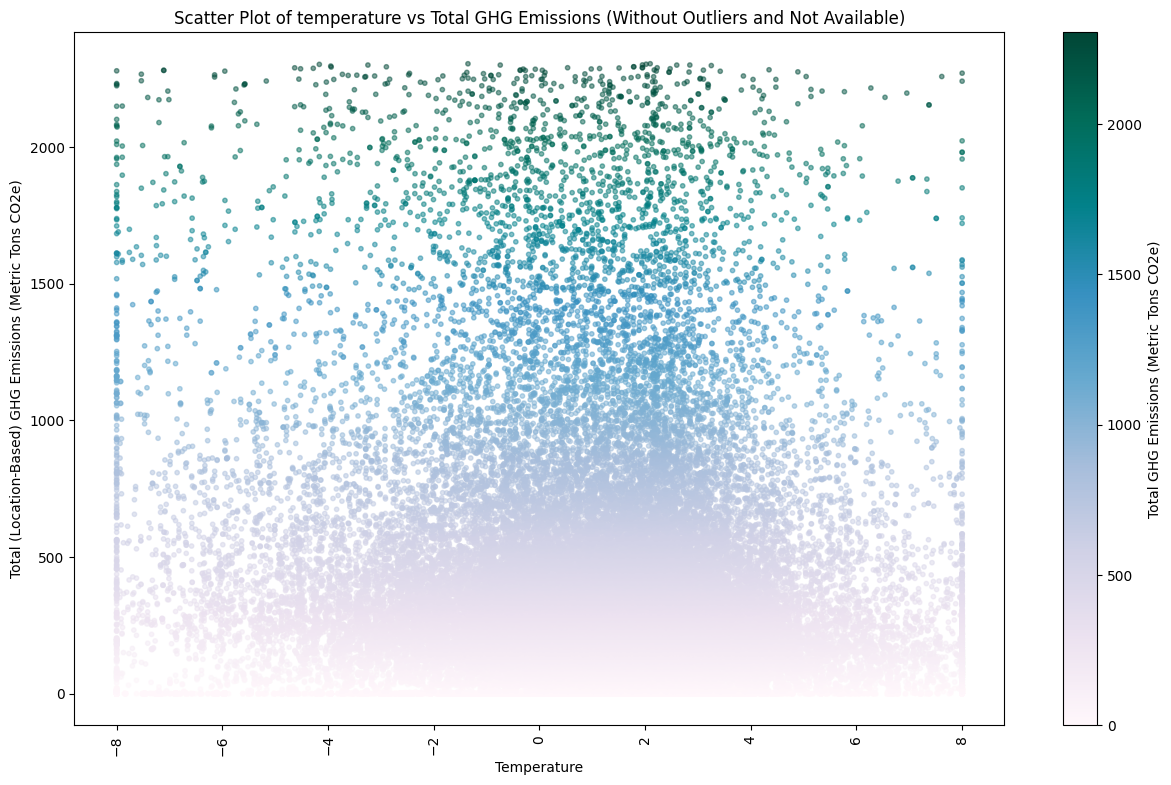

In [ ]:
# Define a threshold using the 95th percentile of the 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
ghg_threshold = df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].quantile(0.95)

# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_clean_filtered3 = df_clean[df_clean['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'] <= ghg_threshold]


# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].min(),
                     vmax=df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']))



# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_clean_filtered['temperature'],
            df_clean_filtered['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'],
            alpha=0.5, s=10,c=colors)
plt.xlabel('Temperature')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Scatter Plot of temperature vs Total GHG Emissions (Without Outliers and Not Available)')
plt.xticks(rotation=90)
# Add a colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='Total GHG Emissions (Metric Tons CO2e)')
plt.show()


<ipython-input-215-7a32ee13ea7d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='major use type', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',


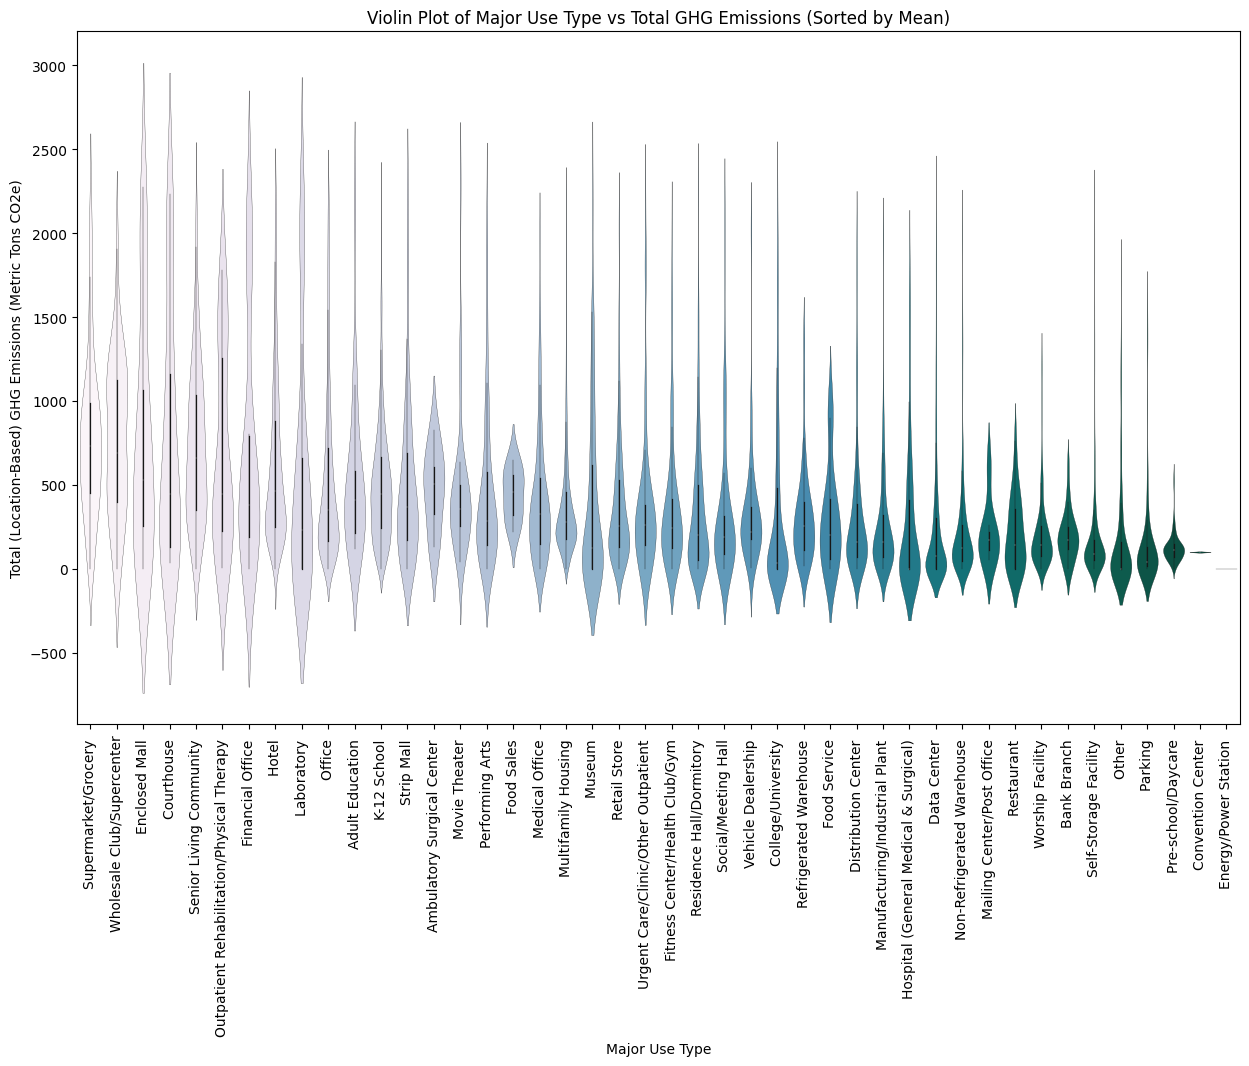

In [ ]:


# Calculate the mean of GHG emissions for each 'major use type'
mean_order = df_clean_filtered3.groupby('major use type')['Total (Location-Based) GHG Emissions (Metric Tons CO2e)'].mean().sort_values(ascending=False).index

# Create the violin plot with sorted x-axis
plt.figure(figsize=(15, 9))
sns.violinplot(x='major use type', y='Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
               data=df_clean_filtered3, palette='PuBuGn', linewidth=0.2, order=mean_order)

# Adjust the labels and plot aesthetics
plt.xticks(rotation=90)
plt.xlabel('Major Use Type')
plt.ylabel('Total (Location-Based) GHG Emissions (Metric Tons CO2e)')
plt.title('Violin Plot of Major Use Type vs Total GHG Emissions (Sorted by Mean)')
plt.show()


The plot is sorted in descending order based on the mean value of GHG emissions for each major use type. We can see that some major use  type do contribute to higher GHG emissions.

In [ ]:
# Group by NTA
df_nta = df_energy.groupby('Neighborhood Tabulation Area (NTA) (2020)').agg(
    avg_carbon_emission=('Total (Location-Based) GHG Emissions (Metric Tons CO2e)', np.mean),
    total_reported_buildings=('Neighborhood Tabulation Area (NTA) (2020)', 'size')
).reset_index()

# Display the first few rows of the new dataframe to verify the result
print('First few rows of df_nta:')
df_nta.head()

First few rows of df_nta:


<ipython-input-216-e7c8365541f1>:2: FutureWarning: The provided callable <function mean at 0x7911677f5000> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_nta = df_energy.groupby('Neighborhood Tabulation Area (NTA) (2020)').agg(


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  
0                       232  
1                       708  
2                       337  
3                       473  
4                       356

<ipython-input-217-a296fc2d4877>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('PuBuGn')(norm(df_nta_filtered['avg_carbon_emission']))
<ipython-input-217-a296fc2d4877>:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='avg_carbon_emission)')


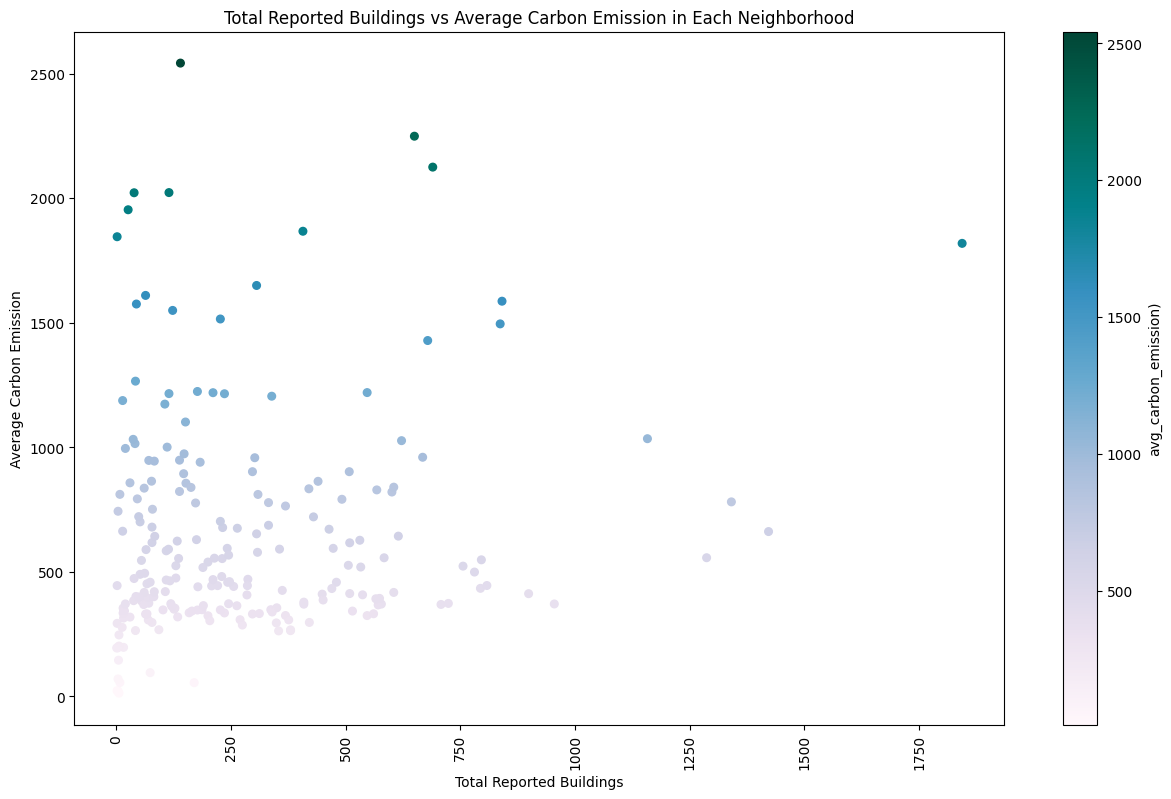

In [ ]:
# Define a threshold using the 95th percentile of the 'Total (Location-Based) GHG Emissions (Metric Tons CO2e)'
avgcarbon_threshold = df_nta['avg_carbon_emission'].quantile(0.95)

# Filter the DataFrame to remove rows where GHG emissions exceed the threshold
df_nta_filtered = df_nta[df_nta['avg_carbon_emission'] <= avgcarbon_threshold]

# Create a colormap based on GHG Emissions for coloring the scatter plot
norm = plt.Normalize(vmin=df_nta_filtered['avg_carbon_emission'].min(),
                     vmax=df_nta_filtered['avg_carbon_emission'].max())
colors = cm.get_cmap('PuBuGn')(norm(df_nta_filtered['avg_carbon_emission']))



# Plot the filtered data
plt.figure(figsize=(15, 9))
plt.scatter(df_nta_filtered['total_reported_buildings'],
            df_nta_filtered['avg_carbon_emission'],
            alpha=1, s=30,c=colors)
plt.xlabel('Total Reported Buildings')
plt.ylabel('Average Carbon Emission')
plt.title('Total Reported Buildings vs Average Carbon Emission in Each Neighborhood')
plt.xticks(rotation=90)
# Add a colorbar
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='PuBuGn'), label='avg_carbon_emission)')
plt.show()


# Read in race demography by NTA of NYC


In [ ]:

file_2_path = 'data/racebyNTA_NYC.csv'

# Reading the CSV files
df_racebyNTA = pd.read_csv(file_2_path, low_memory=False)

In [ ]:
print('NYC Race Demography by NTA(neighborhood)')
print(df_racebyNTA.head())
print(df_racebyNTA.shape)

NYC Race Demography by NTA(neighborhood)
   Year  GeoType   Borough   GeoID  BCT2020                Name  CDType  \
0  2020  NTA2020  Brooklyn  BK0101      NaN          Greenpoint     NaN   
1  2020  NTA2020  Brooklyn  BK0102      NaN        Williamsburg     NaN   
2  2020  NTA2020  Brooklyn  BK0103      NaN  South Williamsburg     NaN   
3  2020  NTA2020  Brooklyn  BK0104      NaN   East Williamsburg     NaN   
4  2020  NTA2020  Brooklyn  BK0201      NaN    Brooklyn Heights     NaN   

   NTAType    Pop2  Pop2P  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP    ONH  \
0        0  38,980  100.0  ...  27,496  70.5  1,025   2.6  2,477   6.4    339   
1        0  64,444  100.0  ...  36,709  57.0  2,340   3.6  4,974   7.7    762   
2        0  47,703  100.0  ...  39,714  83.3  1,217   2.6    363   0.8  1,329   
3        0  52,998  100.0  ...  20,363  38.4  6,110  11.5  5,817  11.0    526   
4        0  25,092  100.0  ...  18,446  73.5    886   3.5  2,282   9.1    161   

   ONHP TwoPlNH  TwoP

The names are simplified in the data as below:  
Total population	Pop2  
Hispanic	Hsp1  
White non-Hispanic	WNH  
Black non-Hispanic	BNH  
Asian non-Hispanic	ANH  
Some other race non-Hispanic	ONH  
Non-Hispanic of two or more races	TwoPlNH  
Ending with P means percentage.  

In [ ]:
# Merge df_nta and df_racebyNTA on 'Neighborhood Tabulation Area (NTA) (2020)' and 'GeoID'
df_combined = pd.merge(
    df_nta,
    df_racebyNTA,
    left_on='Neighborhood Tabulation Area (NTA) (2020)',
    right_on='GeoID',
    how='left'
)

# Display the first few rows of the merged dataframe
print('First few rows of the merged dataframe df_combined:')
df_combined.head()


First few rows of the merged dataframe df_combined:


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  Year  GeoType   Borough   GeoID  BCT2020  \
0                       232  2020  NTA2020  Brooklyn  BK0101      NaN   
1                       708  2020  NTA2020  Brooklyn  BK0102      NaN   
2                       337  2020  NTA2020  Brooklyn  BK0103      NaN   
3                       473  2020  NTA2020  Brooklyn  BK0104      NaN   
4                       356  2020  NTA2020  Brooklyn  BK0201      NaN   

                 Name  CDType  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP  \
0          Greenpoint     NaN  ...  27,496  70.5  1,025   2.6  2,477   6.4   
1        Williamsburg     NaN  ...  36,709  57.0  2,340   3.6  4,974   7.7   
2  South Williamsburg     NaN  ...  39,714  83.3  1,217   2.6    363   0.8   
3   East Williamsburg     NaN  ...  20,363  38.4  6,110  11.5  5,817  11.0   
4    Brooklyn Heights     NaN  ...  18,446  73.5    886   3.5  2,282   9.1   

     ONH ONHP  TwoPlNH TwoPlNHP  
0    339  0.9    1,636      4.2  
1    762  1.2    2,647      4.1  
2  1,329  2.8      945      2.0  
3    526  1.0    1,860      3.5  
4    161  0.6    1,356      5.4  

[5 rows x 25 columns]

In [ ]:
df_combined.columns

Index(['Neighborhood Tabulation Area (NTA) (2020)', 'avg_carbon_emission',
       'total_reported_buildings', 'Year', 'GeoType', 'Borough', 'GeoID',
       'BCT2020', 'Name', 'CDType', 'NTAType', 'Pop2', 'Pop2P', 'Hsp1',
       'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP',
       'TwoPlNH', 'TwoPlNHP'],
      dtype='object')

In [ ]:
df_combined.drop(columns=['GeoID','BCT2020','CDType','NTAType'], inplace=True)

##Summary Statistics:
###Continuous data:
 'avg_carbon_emission',
       'total_reported_buildings', 'Year' 'Pop2', 'Pop2P', 'Hsp1',
       'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP',
       'TwoPlNH', 'TwoPlNHP'
  
###Ordinal data:
nothing

  
###Categorical data:
'Neighborhood Tabulation Area (NTA) (2020)','Name', 'GeoType', 'Borough'

In [ ]:
print('First few rows of the merged dataframe df_combined:')
df_combined.head()

First few rows of the merged dataframe df_combined:


Neighborhood Tabulation Area (NTA) (2020)  avg_carbon_emission  \
0                                    BK0101           677.638326   
1                                    BK0102           368.934720   
2                                    BK0103           347.912537   
3                                    BK0104           594.251915   
4                                    BK0201           591.058120   

   total_reported_buildings  Year  GeoType   Borough                Name  \
0                       232  2020  NTA2020  Brooklyn          Greenpoint   
1                       708  2020  NTA2020  Brooklyn        Williamsburg   
2                       337  2020  NTA2020  Brooklyn  South Williamsburg   
3                       473  2020  NTA2020  Brooklyn   East Williamsburg   
4                       356  2020  NTA2020  Brooklyn    Brooklyn Heights   

     Pop2  Pop2P    Hsp1  ...     WNH  WNHP    BNH  BNHP    ANH  ANHP    ONH  \
0  38,980  100.0   6,007  ...  27,496  70.5  1,025   2.6  2,477   6.4    339   
1  64,444  100.0  17,012  ...  36,709  57.0  2,340   3.6  4,974   7.7    762   
2  47,703  100.0   4,135  ...  39,714  83.3  1,217   2.6    363   0.8  1,329   
3  52,998  100.0  18,322  ...  20,363  38.4  6,110  11.5  5,817  11.0    526   
4  25,092  100.0   1,961  ...  18,446  73.5    886   3.5  2,282   9.1    161   

  ONHP  TwoPlNH TwoPlNHP  
0  0.9    1,636      4.2  
1  1.2    2,647      4.1  
2  2.8      945      2.0  
3  1.0    1,860      3.5  
4  0.6    1,356      5.4  

[5 rows x 21 columns]

In [ ]:
columns_continuous_nta = ['avg_carbon_emission', 'total_reported_buildings', 'Year', 'Pop2', 'Pop2P', 'Hsp1', 'Hsp1P', 'WNH', 'WNHP', 'BNH', 'BNHP', 'ANH', 'ANHP', 'ONH', 'ONHP', 'TwoPlNH', 'TwoPlNHP']
df_combined[columns_continuous_nta].describe()



avg_carbon_emission  total_reported_buildings    Year  Pop2P  \
count           230.000000                230.000000   230.0  227.0   
mean           1091.548428                268.656522  2020.0  100.0   
std            2730.393196                282.334790     0.0    0.0   
min              12.983333                  1.000000  2020.0  100.0   
25%             363.863536                 64.000000  2020.0  100.0   
50%             518.185477                177.500000  2020.0  100.0   
75%             856.885667                380.000000  2020.0  100.0   
max           30170.497500               1844.000000  2020.0  100.0   

            Hsp1P        WNHP        BNHP        ANHP        ONHP    TwoPlNHP  
count  225.000000  217.000000  219.000000  209.000000  208.000000  219.000000  
mean    30.285333   30.579263   20.964840   15.608612    1.928365    4.551598  
std     21.208594   25.330464   22.109197   15.748047    2.994409    6.076586  
min      5.600000    1.100000    0.600000    0.300000    0.300000    0.300000  
25%     12.800000    6.800000    3.450000    3.900000    0.900000    2.000000  
50%     22.400000   23.200000   12.400000   10.600000    1.100000    3.300000  
75%     42.900000   52.300000   29.950000   21.300000    1.500000    4.750000  
max    100.000000  100.000000   84.500000   77.500000   28.600000   50.000000

In [ ]:

columns_categorical_nta = ['Neighborhood Tabulation Area (NTA) (2020)','Name', 'GeoType', 'Borough']
for column in columns_categorical_nta:
    print(f"\nFrequency counts for {column}:")
    print(df_combined[column].value_counts())


Frequency counts for Neighborhood Tabulation Area (NTA) (2020):
Neighborhood Tabulation Area (NTA) (2020)
SI9592    1
BK0101    1
BK0102    1
BK0103    1
BK0104    1
         ..
BK0301    1
BK0302    1
BK0401    1
BK0402    1
BK0501    1
Name: count, Length: 230, dtype: int64

Frequency counts for Name:
Name
Miller Field                 1
Greenpoint                   1
Williamsburg                 1
South Williamsburg           1
East Williamsburg            1
                            ..
Bedford-Stuyvesant (West)    1
Bedford-Stuyvesant (East)    1
Bushwick (West)              1
Bushwick (East)              1
Cypress Hills                1
Name: count, Length: 230, dtype: int64

Frequency counts for GeoType:
GeoType
NTA2020    230
Name: count, dtype: int64

Frequency counts for Borough:
Borough
Queens           70
Brooklyn         59
Bronx            45
Manhattan        36
Staten Island    20
Name: count, dtype: int64


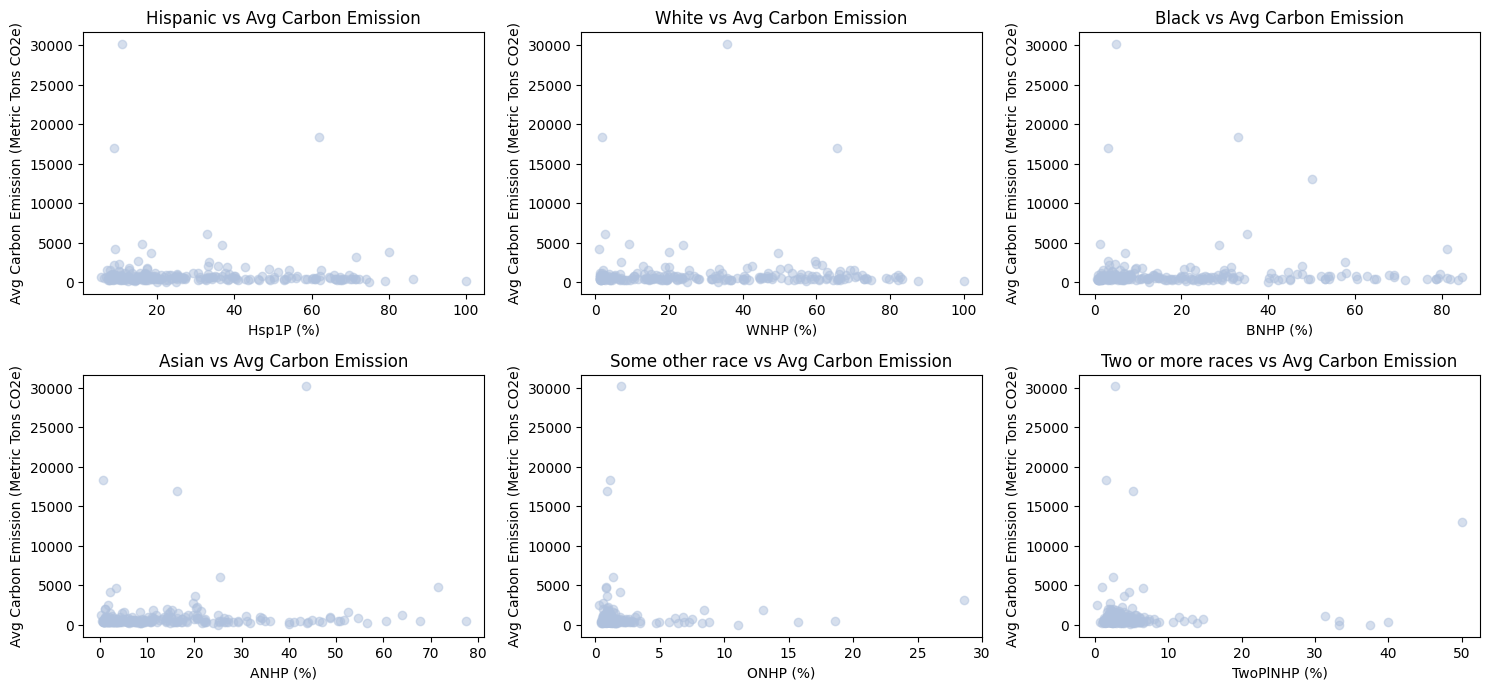

In [ ]:

race_percentage_columns = ['Hsp1P', 'WNHP', 'BNHP', 'ANHP', 'ONHP', 'TwoPlNHP']
race_names = ['Hispanic', 'White', 'Black', 'Asian', 'Some other race', 'Two or more races']




plt.figure(figsize=(15, 10))

for i, race_col in enumerate(race_percentage_columns, 1):
    plt.subplot(3, 3, i)
    # Using plt.scatter with the specified color
    plt.scatter(x=df_combined[race_col], y=df_combined['avg_carbon_emission'], c='#afc1dd',alpha=0.5)
    plt.xlabel(f'{race_col} (%)')
    plt.ylabel('Avg Carbon Emission (Metric Tons CO2e)')
    plt.title(f'{race_names[i - 1]} vs Avg Carbon Emission')

plt.tight_layout()
plt.show()


There doesn’t appear to be a strong linear relationship between the percentage of any specific racial group and carbon emissions.

#Data Preprocessing
###Handle Missing Data:
* Identify missing data and decide on appropriate imputation methods
I decide to drop columns with excessive missing data since they aren't critical for the analysis.  


###Outliers:
* There are significant outliers in total GHG emission and sum floor area.  If we do not filter it, the distribution on the plots will be skewed and the training and testing result would has very high MSE.

###Feature Engineering:
* I create new features from a temperature GIS data by getting the relative temperature of each building based on location. I also get the sum floor area and major use type from gross floor area of different use types. I also created a new data after categorization based on NTA.

###Categorization:
* I tried categorizing based on NTA to figure out the relationship between carbon emission and building counts and race demography.


###Scale:
* I do MinMax Scale later with data splitting to improve the model performance.

###One-hot encoding
* I do one hot encoding for major use type because in the EDA we can see that this is an important variable affecting the total GHG emissions and it is categorical.

#Data Splitting
Simply select the total GHG emissions as target, and major use type and sum floor area as X, do basic 80-20 split, use gradient boost to test if the split is reasonable

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor

X = df_clean_filtered3[['major use type', 'sum floor area']]  # Features
y = df_clean_filtered3['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']  # Target variable

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['sum floor area']),
        ('cat', OneHotEncoder(), ['major use type'])
    ]
)

model = GradientBoostingRegressor(random_state=42)


pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
     ('model', model)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Shapes:')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

Shapes:
X_train shape: (45159, 2)
X_test shape: (11290, 2)
y_train shape: (45159,)
y_test shape: (11290,)


# Test on Regression

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 57467.411654560434
R-squared (R²): 0.6294051623624535
Mean Absolute Error (MAE): 143.36423004626934
Root Mean Squared Error (RMSE): 239.7236151374337


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the hyperparameters to tune
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7]
}

# Set up the grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', verbose=1)

# Perform the search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and R-squared score
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best R-squared score: {grid_search.best_score_}')


Fitting 5 folds for each of 27 candidates, totalling 135 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 89, in _cached_call
    result, _ = _get_response_values(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_response.py", line 239, in _get_response_values
    y_pred, pos_label = predic

KeyboardInterrupt: 

#New Attempt with more reasonable split


1.   Group data by 'major use type'. because I need to make sure every major use type present in both train and test sets.
2.   Split the data into training and test sets, ensuring that 'NYC Building Identification Number (BIN)' does not overlap between them. This is because we want each building only present in either train or test, not both, to prevent data leakage.
3.   Use KFold for cross-validation, but keep the 'major use type' for stratification. This is preventing overfitting through cross-validation.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedGroupKFold



# Filter the dataset based on the mask
X = df_clean_filtered3[mask].drop(columns=['Total (Location-Based) GHG Emissions (Metric Tons CO2e)',
                                     'Latitude', 'Longitude', 'Calendar Year', 'ENERGY STAR Score', 'temperature',
                                     'Property Name', 'Borough', 'Neighborhood Tabulation Area (NTA) (2020)',
                                     'geometry', 'Net Emissions (Metric Tons CO2e)','Total (Location-Based) GHG Emissions (Metric Tons CO2e)'])  # Ensure the building ID is dropped
y = df_clean_filtered3[mask]['Total (Location-Based) GHG Emissions (Metric Tons CO2e)']

print('X columns before preprocessing:')
print(X.columns)

print('The shape of X:')
print(X.shape)

print('Missing data in X:')
X.isnull().sum()



X columns before preprocessing:
Index(['NYC Building Identification Number (BIN)', 'Year Built',
       'sum floor area', 'major use type'],
      dtype='object')
The shape of X:
(56449, 4)
Missing data in X:


NYC Building Identification Number (BIN)    0
Year Built                                  0
sum floor area                              0
major use type                              0
dtype: int64

In [ ]:
print('y target variable:')
print(y.name)

print('The shape of y:')
print(y.shape)

print('Missing data in y:')
y.isnull().sum()

y target variable:
Total (Location-Based) GHG Emissions (Metric Tons CO2e)
The shape of y:
(56449,)
Missing data in y:


0

In [ ]:

help(StratifiedGroupKFold)

Help on class StratifiedGroupKFold in module sklearn.model_selection._split:

class StratifiedGroupKFold(GroupsConsumerMixin, _BaseKFold)
 |  StratifiedGroupKFold(n_splits=5, shuffle=False, random_state=None)
 |  
 |  Stratified K-Fold iterator variant with non-overlapping groups.
 |  
 |  This cross-validation object is a variation of StratifiedKFold attempts to
 |  return stratified folds with non-overlapping groups. The folds are made by
 |  preserving the percentage of samples for each class.
 |  
 |  Each group will appear exactly once in the test set across all folds (the
 |  number of distinct groups has to be at least equal to the number of folds).
 |  
 |  The difference between :class:`GroupKFold`
 |  and `StratifiedGroupKFold` is that
 |  the former attempts to create balanced folds such that the number of
 |  distinct groups is approximately the same in each fold, whereas
 |  `StratifiedGroupKFold` attempts to create folds which preserve the
 |  percentage of samples for ea

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print("First few rows of X:")
print(X.head())
print(X.shape)

# Step 1: Separate numerical and one-hot encoded categorical features
num_features = 'sum floor area'
cat_features = X.columns.difference([num_features])  # Select categorical (one-hot encoded) columns


# Step 2: Apply the scaler to numerical features only
scaler = MinMaxScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[[num_features]]), columns=[num_features])

# Step 3: Concatenate scaled numerical features with categorical features
X= pd.concat([X_num, X[cat_features].reset_index(drop=True)], axis=1)

# Now, X_scaled has scaled numerical features and unscaled one-hot encoded categorical features
print("First few rows of X scaled:")
print(X.head())
print(X.shape)

First few rows of X:
  NYC Building Identification Number (BIN)  Year Built  sum floor area  \
0                                  4059918        1930         51749.0   
1                                  2047795        1960         52941.0   
2                                  4300145        1941         35196.0   
3                                  1052383        1898        107234.0   
4                                  4017180        1911         75191.0   

                major use type  
0  Non-Refrigerated Warehouse   
1         Multifamily Housing   
2                      Office   
3         Multifamily Housing   
4              Medical Office   
(56449, 4)
First few rows of X scaled:
   sum floor area NYC Building Identification Number (BIN)  Year Built  \
0        0.003822                                  4059918        1930   
1        0.003910                                  2047795        1960   
2        0.002599                                  4300145        1941   
3

In [ ]:
print('X columns before preprocessing:')
print(X.columns)

print('The shape of X:')
print(X.shape)

print('Missing data in X:')
X.isnull().sum()

print('y target variable:')
print(y.name)

print('The shape of y:')
print(y.shape)

print('Missing data in y:')
y.isnull().sum()

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

X columns before preprocessing:
Index(['sum floor area', 'NYC Building Identification Number (BIN)',
       'Year Built', 'major use type'],
      dtype='object')
The shape of X:
(56449, 4)
Missing data in X:
y target variable:
Total (Location-Based) GHG Emissions (Metric Tons CO2e)
The shape of y:
(56449,)
Missing data in y:


Counts in each major use type: major use type
Multifamily Housing                            38098
Office                                          4131
K-12 School                                     3613
Data Center                                     2367
Hotel                                           1109
Non-Refrigerated Warehouse                       845
College/University                               729
Retail Store                                     607
Self-Storage Facility                            516
Residence Hall/Dormitory                         432
Worship Facility                                 400
Manufacturing/Industrial Plant                   356
Distribution Center                              313
Pre-school/Daycare                               300
Senior Living Community                          290
Medical Office                                   246
Supermarket/Grocery                              204
Strip Mall                                       204


<ipython-input-307-dc2d2e4cdb3a>:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  id_check = X.loc[mask].groupby('major use type').apply(check_same_id)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


Shapes:
X_train shape: (50866, 3)
X_test shape: (5583, 3)
y_train shape: (50866,)
y_test shape: (5583,)



Counts in each major use type: major use type
Multifamily Housing                            34356
Office                                          3723
K-12 School                                     3232
Data Center                                     2167
Hotel                                           1008
Non-Refrigerated Warehouse                       737
College/University                               643
Retail Store                                     562
Self-Storage Facility                            471
Residence Hall/Dormitory                         383
Worship Facility                                 347
Manufacturing/Industrial Plant                   331
Pre-school/Daycare                               280
Distribution Center                              277
Senior Living Community                          262
Medical Office                                   221

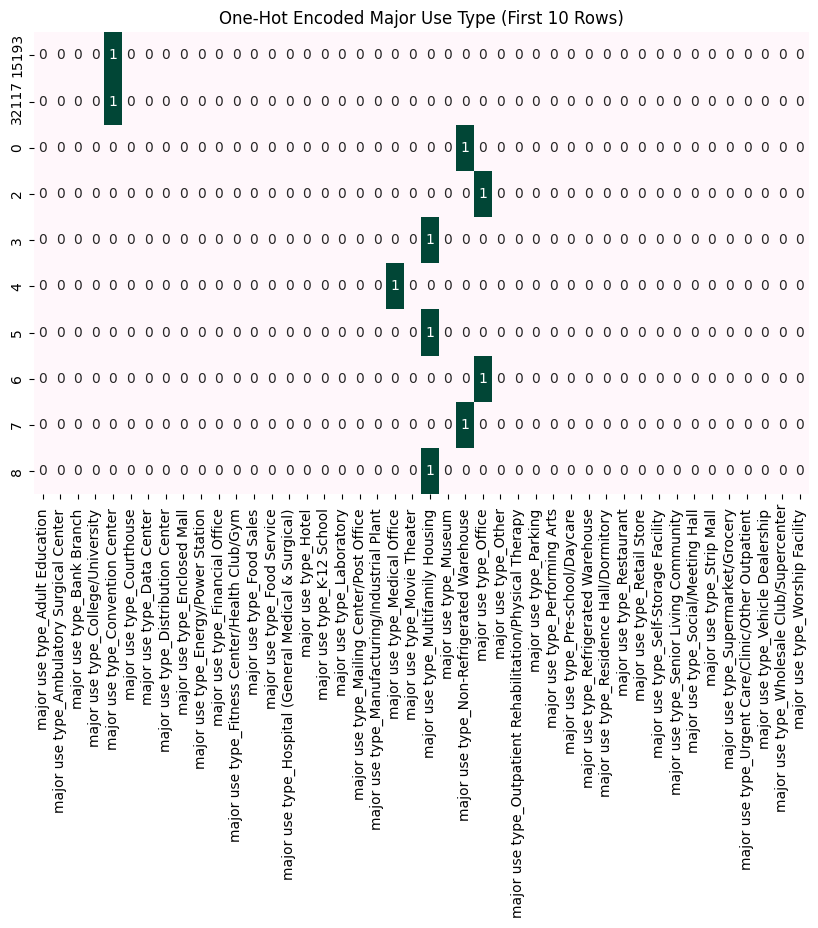

Total columns added: 44
One-hot encoded feature names:
['major use type_Adult Education '
 'major use type_Ambulatory Surgical Center '
 'major use type_Bank Branch ' 'major use type_College/University '
 'major use type_Convention Center ' 'major use type_Courthouse '
 'major use type_Data Center ' 'major use type_Distribution Center '
 'major use type_Enclosed Mall ' 'major use type_Energy/Power Station '
 'major use type_Financial Office '
 'major use type_Fitness Center/Health Club/Gym '
 'major use type_Food Sales ' 'major use type_Food Service '
 'major use type_Hospital (General Medical & Surgical) '
 'major use type_Hotel ' 'major use type_K-12 School '
 'major use type_Laboratory ' 'major use type_Mailing Center/Post Office '
 'major use type_Manufacturing/Industrial Plant '
 'major use type_Medical Office ' 'major use type_Movie Theater '
 'major use type_Multifamily Housing ' 'major use type_Museum '
 'major use type_Non-Refrigerated Warehouse ' 'major use type_Office '
 'ma

In [ ]:

# Remove classes based on type occurrences
min_samples = 2
type_ids = X['major use type']

# Count occurrences of each type
type_counts = type_ids.value_counts()
print('Counts in each major use type:', type_counts)
print('How many Types in total: ',len(train_type_counts))

# Create a mask for the dataset based on valid types
mask = type_ids.notna()


type_ids = type_ids[mask]  # Also filter types
building_ids = X.loc[mask, 'NYC Building Identification Number (BIN)']



# Step 1: Identify rows with consistent building IDs for each major use type
def check_same_id(group):
    return group['NYC Building Identification Number (BIN)'].nunique() == 1

# Group data by 'major use type' and check for consistent IDs
id_check = X.loc[mask].groupby('major use type').apply(check_same_id)

# Find major use types with consistent IDs
consistent_ids = id_check[id_check == True].index


# Data with consistent IDs will go into the training set
consistent_mask = X['major use type'].isin(consistent_ids)
X_consistent = X[consistent_mask]
y_consistent = y[consistent_mask]
type_ids_consistent = type_ids[consistent_mask]
building_ids_consistent = building_ids[consistent_mask]

# Step 2: Keep all inconsistent data
inconsistent_mask = ~consistent_mask
X_inconsistent = X[inconsistent_mask]
y_inconsistent = y[inconsistent_mask]
type_ids_inconsistent = type_ids[inconsistent_mask]  # This will be used for stratifying
building_ids_inconsistent = building_ids[inconsistent_mask]

# Create a stratified group K-fold object
stratified_group_kfold = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

# Perform the stratified group split
for i_train, i_test in stratified_group_kfold.split(X_inconsistent, type_ids_inconsistent, building_ids_inconsistent):
    X_train_inconsistent, y_train_inconsistent = X_inconsistent.iloc[i_train], y_inconsistent.iloc[i_train]
    X_test_inconsistent, y_test_inconsistent = X_inconsistent.iloc[i_test], y_inconsistent.iloc[i_test]

# Step 3: Combine the consistent data with the training part of the inconsistent data
X_train = pd.concat([X_consistent, X_train_inconsistent])
y_train = pd.concat([y_consistent, y_train_inconsistent])

# Prepare the test set
X_test = X_test_inconsistent
y_test = y_test_inconsistent

building_ids_train = X_train['NYC Building Identification Number (BIN)']

# Drop the building ID column from training and test sets if present
if 'NYC Building Identification Number (BIN)' in X_train.columns:
    X_train = X_train.drop(columns=['NYC Building Identification Number (BIN)'])

if 'NYC Building Identification Number (BIN)' in X_test.columns:
    X_test = X_test.drop(columns=['NYC Building Identification Number (BIN)'])

# Print the shapes of the datasets
print('Shapes:')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print('\n\n')
train_type_counts = X_train['major use type'].value_counts()
print('Counts in each major use type:', train_type_counts)
print('How many Types in trai: ',len(train_type_counts))
print('\n\n')
test_type_counts = X_test['major use type'].value_counts()
print('Counts in each major use type:', test_type_counts)
print('How many Types in test: ',len(test_type_counts))
print('\n\n')

# Set up One-Hot Encoding for the 'major use type' column
onehot_ftrs = ['major use type']
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit the encoder on the major use type
enc.fit(X[onehot_ftrs])

# Transform the 'major use type' column for both the train and test data
X_train_encoded = enc.transform(X_train[onehot_ftrs])

# Convert the encoded values into a DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded,
                                      columns=enc.get_feature_names_out(onehot_ftrs),
                                      index=X_train.index)
# Show the first few rows of the encoded dataset
print("First 5 rows of the one-hot encoded dataset:")
print(X_train_encoded_df.head())

# Visualize the result using a heatmap (binary visualization)
plt.figure(figsize=(10, 6))
sns.heatmap(X_train_encoded_df.head(10), cmap='PuBuGn', annot=True, cbar=False)
plt.title('One-Hot Encoded Major Use Type (First 10 Rows)')
plt.show()

# Summarize the one-hot encoding
print(f"Total columns added: {len(enc.get_feature_names_out(onehot_ftrs))}")
print("One-hot encoded feature names:")
print(enc.get_feature_names_out(onehot_ftrs))


# Transform the 'major use type' column for both the train and test data
X_test_encoded = enc.transform(X_test[onehot_ftrs])

# Convert the encoded values into a DataFrame
X_test_encoded_df = pd.DataFrame(X_test_encoded,
                                      columns=enc.get_feature_names_out(onehot_ftrs),
                                      index=X_test.index)

common_columns = X_train.columns.difference(onehot_ftrs)

# Concatenate the remaining features with the encoded columns
X_train = pd.concat([X_train[common_columns].reset_index(drop=True), X_train_encoded_df.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test[common_columns].reset_index(drop=True), X_test_encoded_df.reset_index(drop=True)], axis=1)



# Step 4: Train the model using the combined training data
model = XGBRegressor()
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Calculate and print the MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


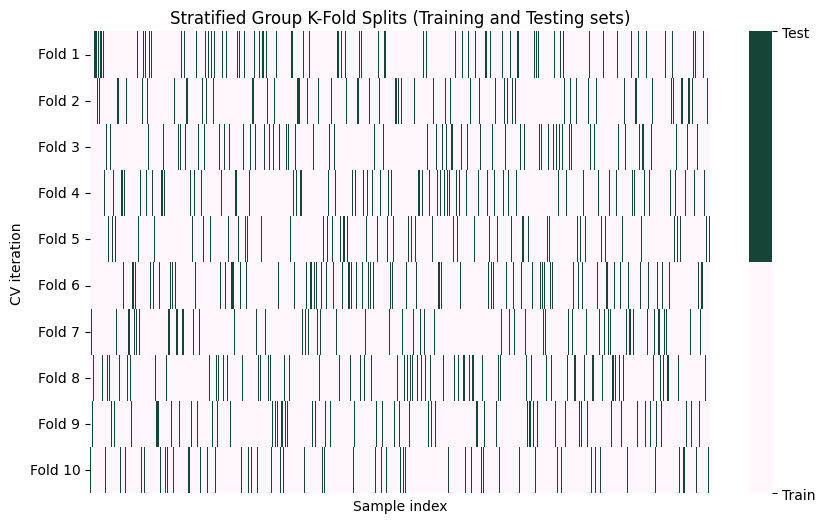

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedGroupKFold

# Create a stratified group K-fold object
stratified_group_kfold = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)

# Create arrays to store train/test split indices and groups for visualization
n_samples = X_inconsistent.shape[0]
splits = np.zeros((10, n_samples))
split_index = 0

# Perform the stratified group split and store the splits
for train_idx, test_idx in stratified_group_kfold.split(X_inconsistent, type_ids_inconsistent, building_ids_inconsistent):
    splits[split_index, test_idx] = 1  # Mark test indices
    split_index += 1

# Create a custom colormap with discrete values for 0 (test) and 1 (train)
cmap = sns.color_palette(['#fff7fb', '#164437'], as_cmap=True)

# Visualize the split with a fixed color bar for 0 (testing) and 1 (training)
plt.figure(figsize=(10, 6))
ax = sns.heatmap(splits, cmap=cmap, cbar=True, vmin=0, vmax=1, yticklabels=[f'Fold {i}' for i in range(1, 11)], xticklabels=False)

# Customize the colorbar
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Train','Test'])

plt.xlabel('Sample index')
plt.ylabel('CV iteration')
plt.title('Stratified Group K-Fold Splits (Training and Testing sets)')
plt.show()


In [ ]:
# Step 4: GroupKFold cross-validation using building IDs
kf = GroupKFold(n_splits=10)

# Prepare to collect cross-validation scores
test_scores = []
i = 0

# Cross-validation loop using GroupKFold with aligned building IDs as groups
for train_index, val_index in kf.split(X_train, y_train, groups=building_ids_train):
    print(f'New fold {i}')

    X_fold_train = X_train.iloc[train_index]
    y_fold_train = y_train.iloc[train_index]
    X_fold_val = X_train.iloc[val_index]
    y_fold_val = y_train.iloc[val_index]

    model = XGBRegressor(random_state=42)

    # Train the model on the fold's training data
    model.fit(X_fold_train, y_fold_train)

    # Predict on the fold's validation data
    y_pred = model.predict(X_fold_val)


    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_fold_val, y_pred)

    # Calculate R-squared (R²)
    r2 = r2_score(y_fold_val, y_pred)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_fold_val, y_pred)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Print the results
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'R-squared (R²): {r2}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    test_scores.append(mse)
    i += 1

# Step 5: Train the model on the full training set and evaluate on the test set
final_model = XGBRegressor(random_state=42)
final_model.fit(X_train, y_train)

# Predict on the test set
y_test_pred = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)




# Print the results
print('\n\n')
print('Test MSE:', test_mse)
print('Test R-squared (R²):', test_r2)
print('Test Mean Absolute Error (MAE):', test_mae)
print('Test Root Mean Squared Error (RMSE):', test_rmse)
print('\n\n')
print('Average CV MSE:', np.mean(test_scores))


New fold 0
Mean Squared Error (MSE): 59666.419088719354
R-squared (R²): 0.5875521769608745
Mean Absolute Error (MAE): 142.43367853573363
Root Mean Squared Error (RMSE): 244.2671060309172
New fold 1
Mean Squared Error (MSE): 56109.607871359774
R-squared (R²): 0.6292037386327478
Mean Absolute Error (MAE): 135.62087915462996
Root Mean Squared Error (RMSE): 236.87466701055175
New fold 2
Mean Squared Error (MSE): 61321.392817475156
R-squared (R²): 0.6306696488421788
Mean Absolute Error (MAE): 141.86781717217553
Root Mean Squared Error (RMSE): 247.63156668218846
New fold 3
Mean Squared Error (MSE): 53778.40185588928
R-squared (R²): 0.6213820006690136
Mean Absolute Error (MAE): 138.19796129997758
Root Mean Squared Error (RMSE): 231.901707315598
New fold 4
Mean Squared Error (MSE): 58424.23557628668
R-squared (R²): 0.6213674720998872
Mean Absolute Error (MAE): 140.85085215024873
Root Mean Squared Error (RMSE): 241.71105803476738
New fold 5
Mean Squared Error (MSE): 56951.246355382136
R-squared